In [2]:
import dask.dataframe as dd
import pandas as pd
import folium
import datetime
import time
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo
import scipy
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import math
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scipy.signal as sl

In [4]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

In [3]:
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
month.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [5]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)

### Removal of all outliers/erroronous points

In [6]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [7]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


#### Forming clusters

In [8]:
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

#### Plotting the cluster centers

In [9]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

#### Time binning

In [9]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    print(start_pickup_unix)
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [10]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

1420070400


In [11]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319              34         2130  
1  1.420902e+09   9.983193               2         1419  
2  1.420902e+09  10.746269              16         1419  
3  1.420902e+09  16.071429              38         1419  
4  1.420902e+09   9.318378              22         1419

In [12]:
len(jan_2015_frame['pickup_bins'].unique())

4464

In [13]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

#### Smoothing

In [14]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [15]:
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)

In [16]:
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  1986
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  154
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
---------

In [17]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [18]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [19]:
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [20]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  178560


<IPython.core.display.Javascript object>


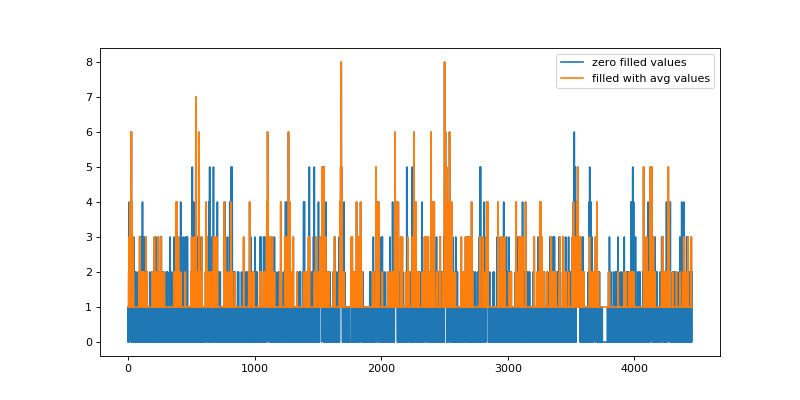

In [21]:
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

#### Fourier Transforms

<IPython.core.display.Javascript object>


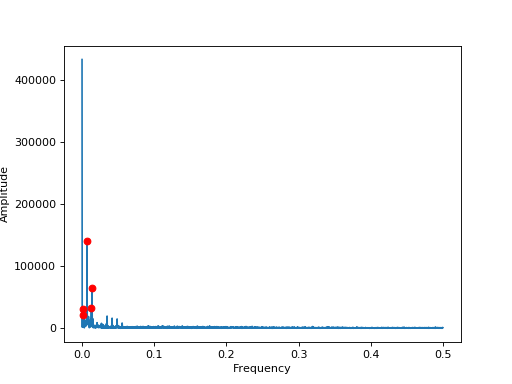

<IPython.core.display.Javascript object>


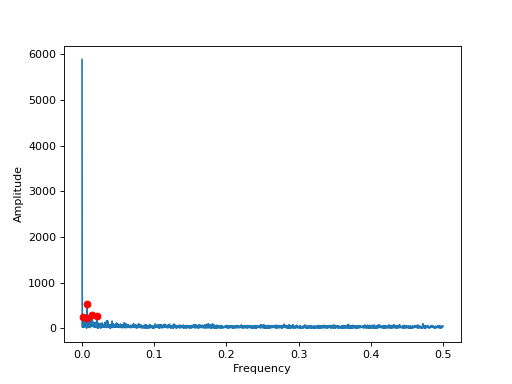

<IPython.core.display.Javascript object>


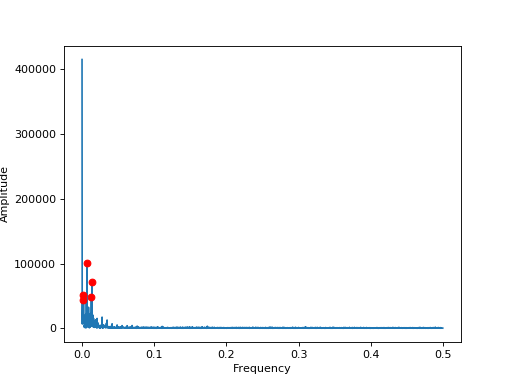

<IPython.core.display.Javascript object>


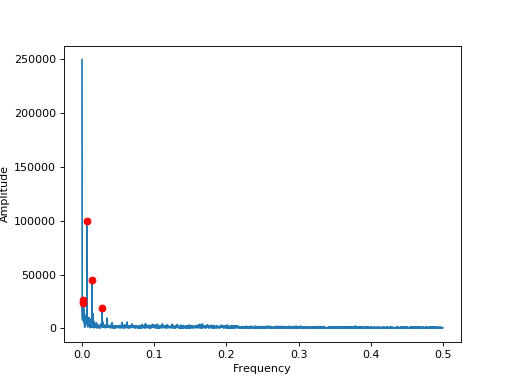

<IPython.core.display.Javascript object>


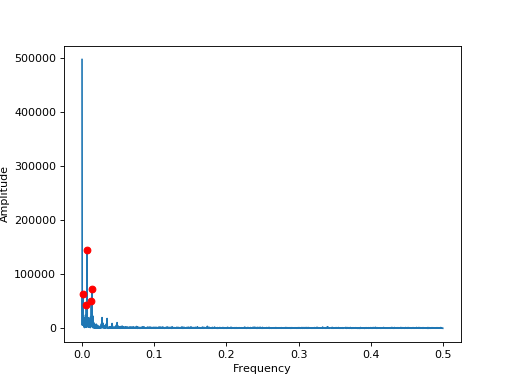

<IPython.core.display.Javascript object>


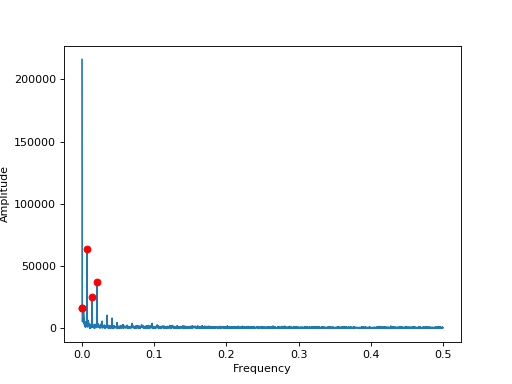

<IPython.core.display.Javascript object>


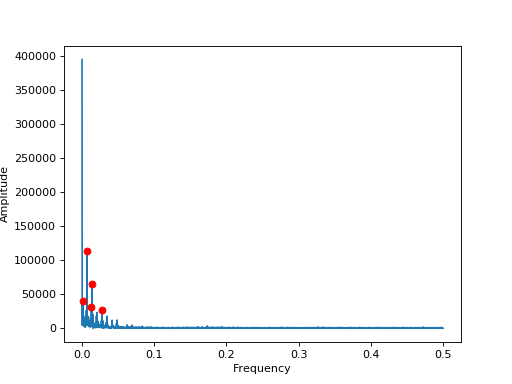

<IPython.core.display.Javascript object>


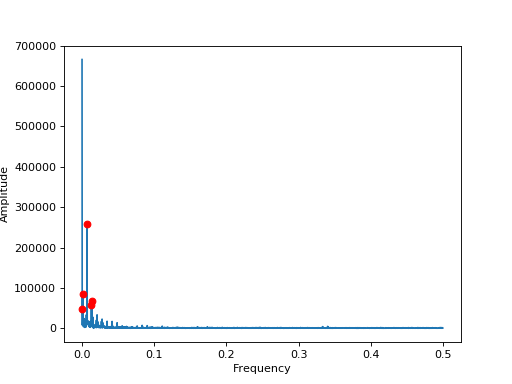

<IPython.core.display.Javascript object>


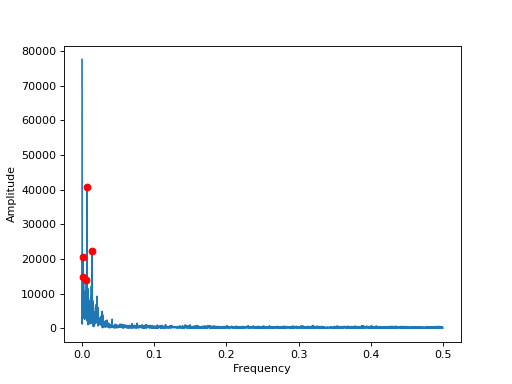

<IPython.core.display.Javascript object>


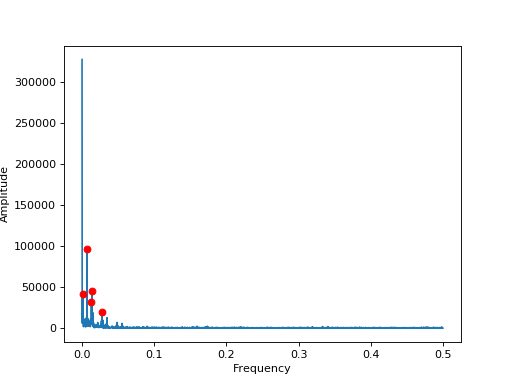

<IPython.core.display.Javascript object>


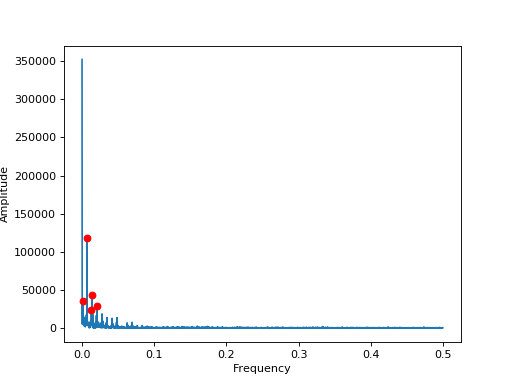

<IPython.core.display.Javascript object>


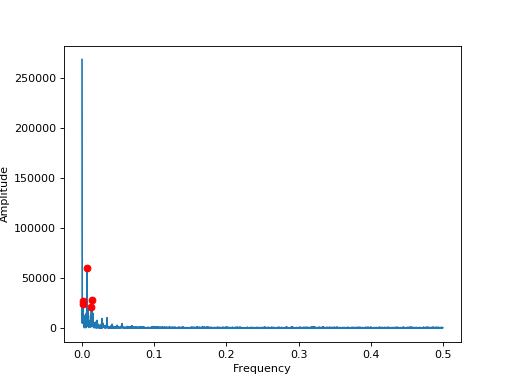

<IPython.core.display.Javascript object>


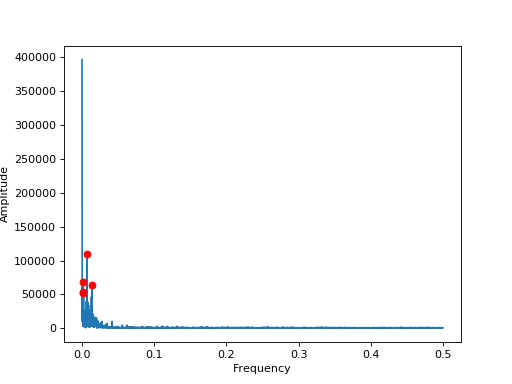

<IPython.core.display.Javascript object>


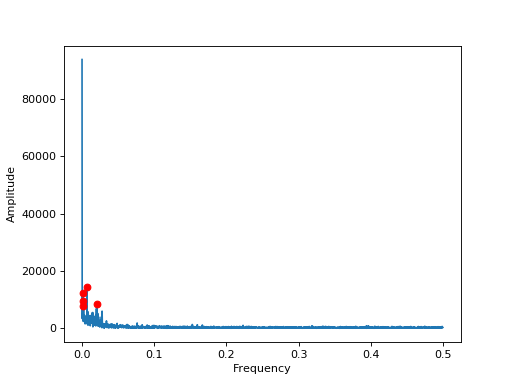

<IPython.core.display.Javascript object>


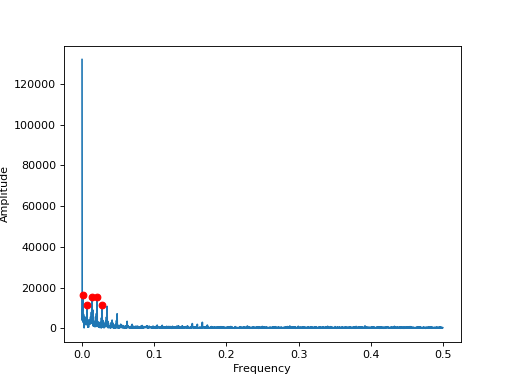

<IPython.core.display.Javascript object>


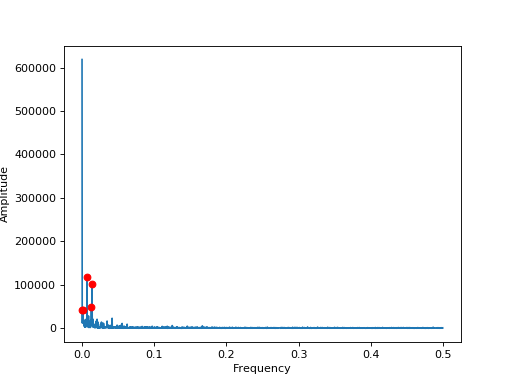

<IPython.core.display.Javascript object>


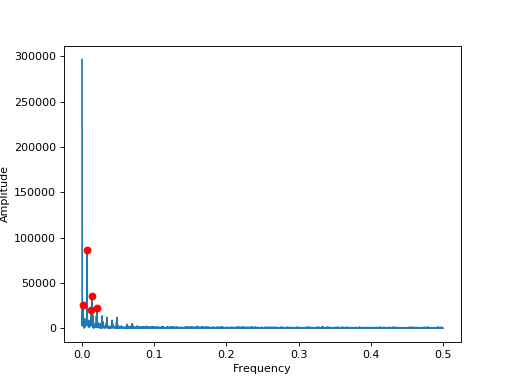

<IPython.core.display.Javascript object>


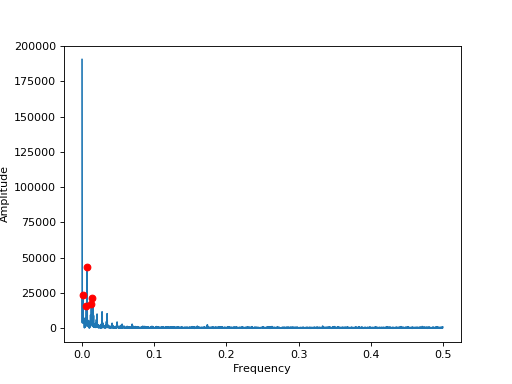

<IPython.core.display.Javascript object>


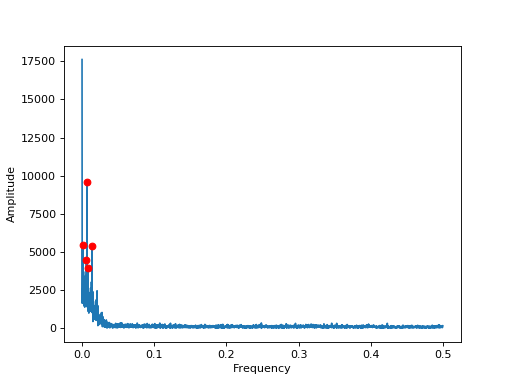

<IPython.core.display.Javascript object>


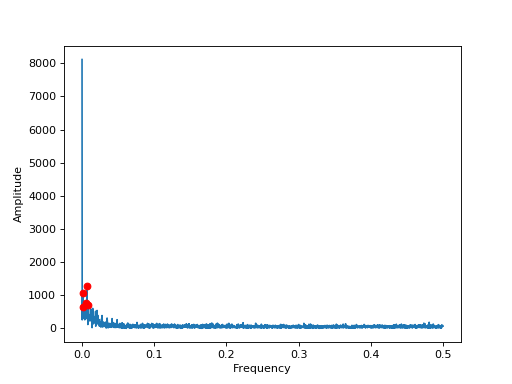

<IPython.core.display.Javascript object>


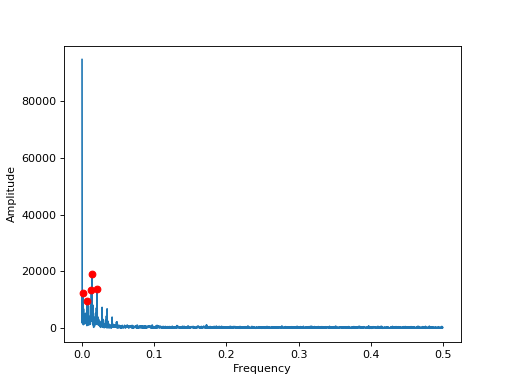

<IPython.core.display.Javascript object>


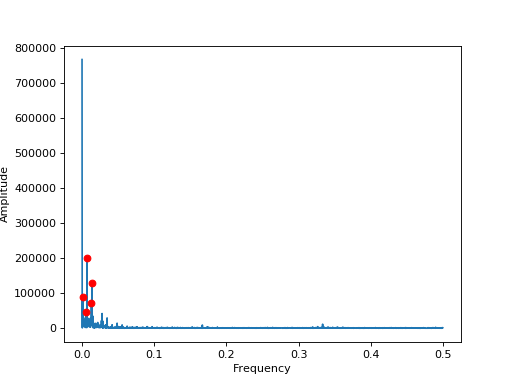

<IPython.core.display.Javascript object>


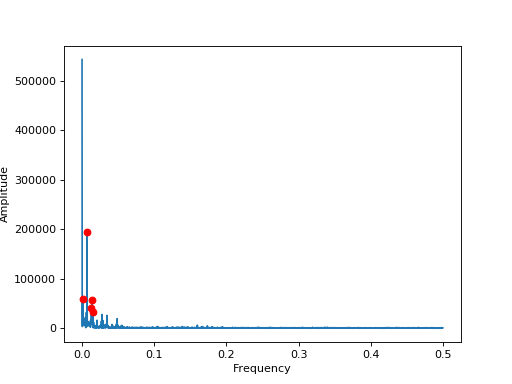

<IPython.core.display.Javascript object>


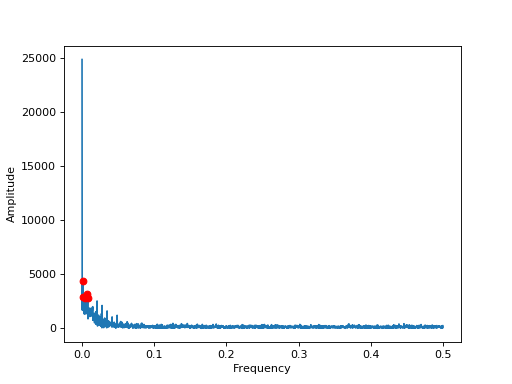

<IPython.core.display.Javascript object>


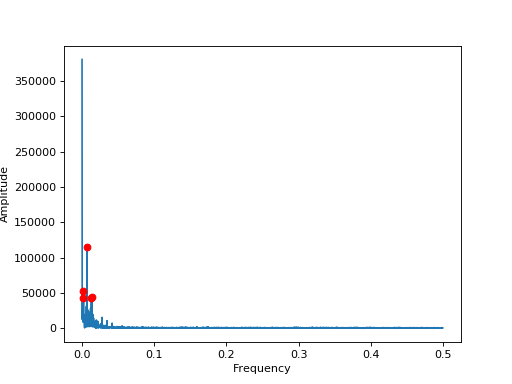

<IPython.core.display.Javascript object>


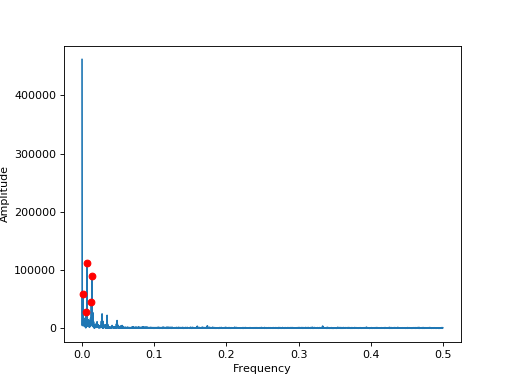

<IPython.core.display.Javascript object>


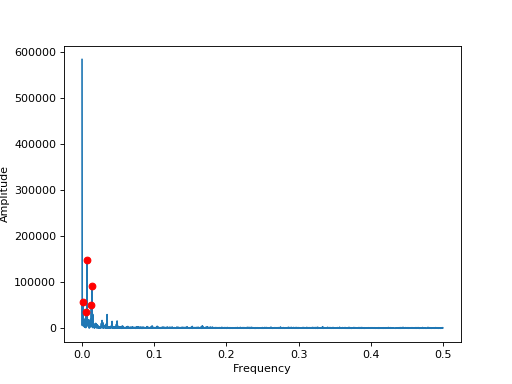

<IPython.core.display.Javascript object>


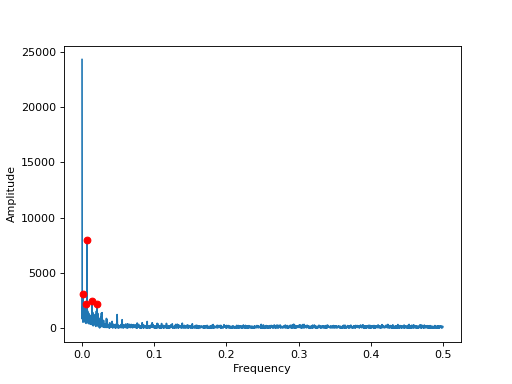

<IPython.core.display.Javascript object>


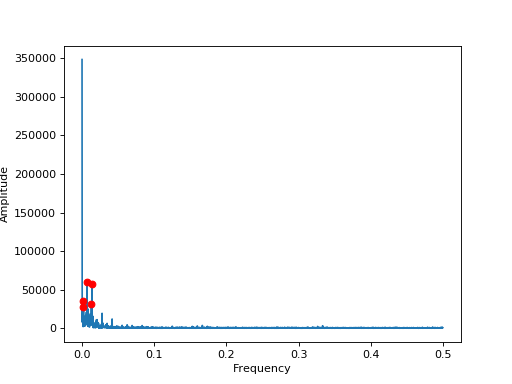

<IPython.core.display.Javascript object>


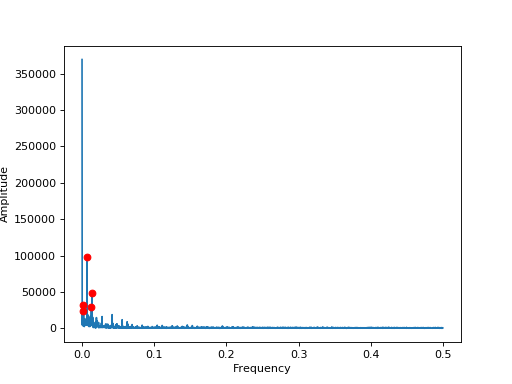

<IPython.core.display.Javascript object>


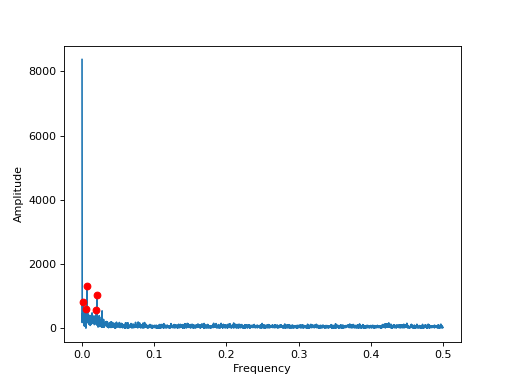

<IPython.core.display.Javascript object>


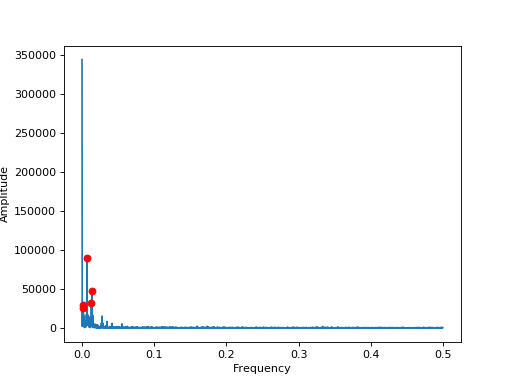

<IPython.core.display.Javascript object>


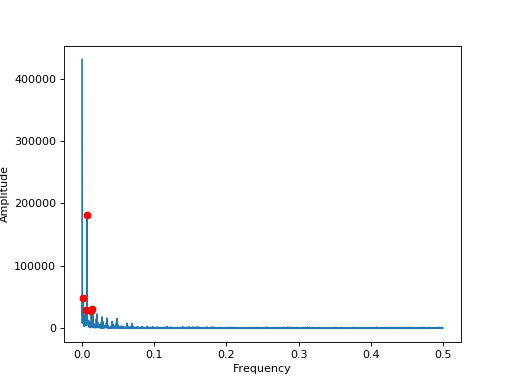

<IPython.core.display.Javascript object>


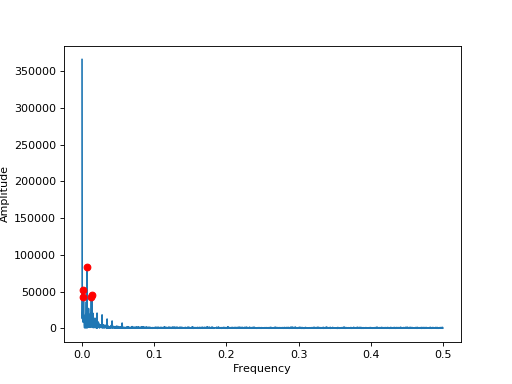

<IPython.core.display.Javascript object>


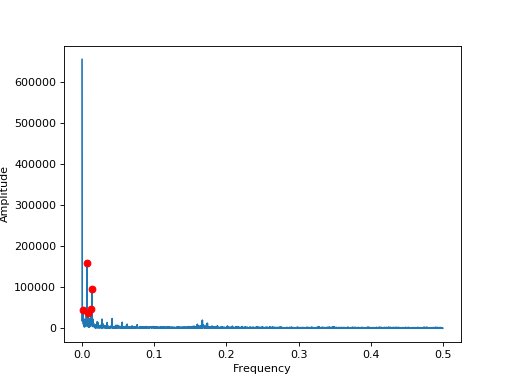

<IPython.core.display.Javascript object>


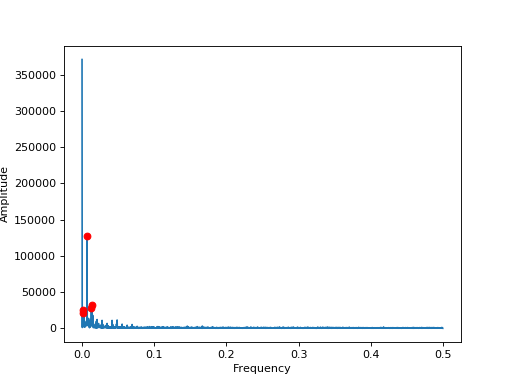

<IPython.core.display.Javascript object>


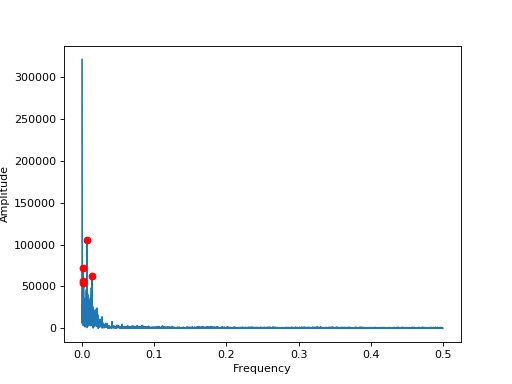

<IPython.core.display.Javascript object>


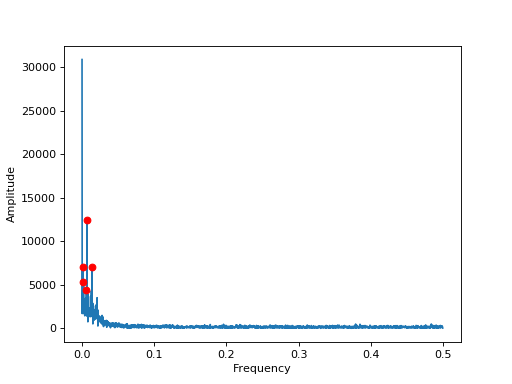

<IPython.core.display.Javascript object>


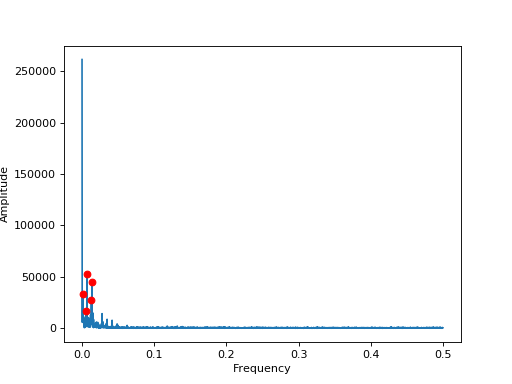

<IPython.core.display.Javascript object>


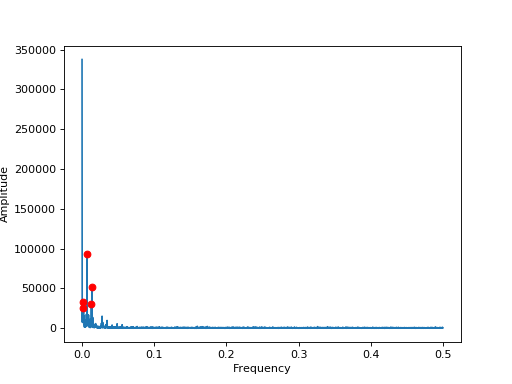

In [22]:
for x in range(40):
    Y    = np.fft.fft(np.array(jan_2015_smooth[4464*x:4464*(x+1)]))
    freq = np.fft.fftfreq(4464)
    #peaks,d = sl.find_peaks(Y,height = 0 )
    #peaks = sl.argrelextrema(Y, np.greater)
    n = len(freq)
    plt.figure()
    d= { y:x for y,x in zip(np.abs(Y)[:int(n/2)],freq[:int(n/2)])  }
    plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
    plt.plot(abs(np.array([d[x] for x in abs(np.array(sorted(np.abs(Y)[:int(n/2)])[-6:-1]))])) , abs(np.array(sorted(np.abs(Y)[:int(n/2)])[-6:-1])),'ro', label = 'peaks' )
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

#### Preparing data

In [5]:
from pickleshare import *
db = PickleShareDB('~/db_files')
#db.clear()

### Regression Models

In [4]:
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame

In [21]:
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
1451606400
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
1454284800
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444


In [24]:
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [25]:
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

In [7]:
db['jan_2016_smooth']=jan_2016_smooth
db['feb_2016_smooth']=feb_2016_smooth
db['mar_2016_smooth']=mar_2016_smooth

In [6]:
jan_2016_smooth=db['jan_2016_smooth']
feb_2016_smooth=db['feb_2016_smooth']
mar_2016_smooth=db['mar_2016_smooth']

In [5]:
regions_cum = []
for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

In [8]:
db['regions_cum']=regions_cum

In [7]:
regions_cum = db['regions_cum']

<IPython.core.display.Javascript object>


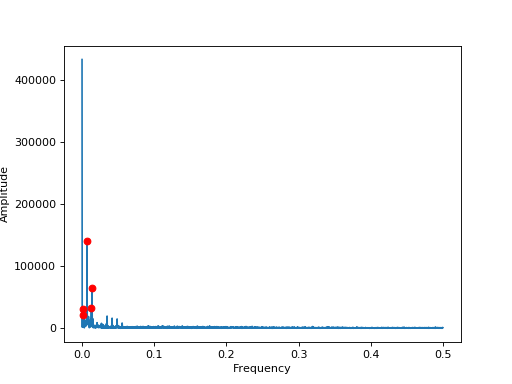

<IPython.core.display.Javascript object>


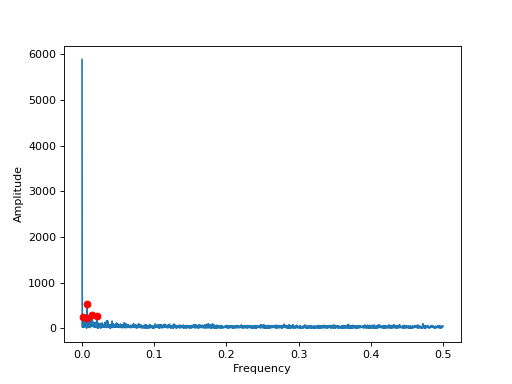

<IPython.core.display.Javascript object>


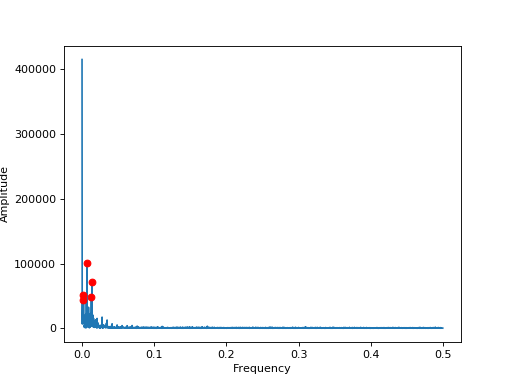

<IPython.core.display.Javascript object>


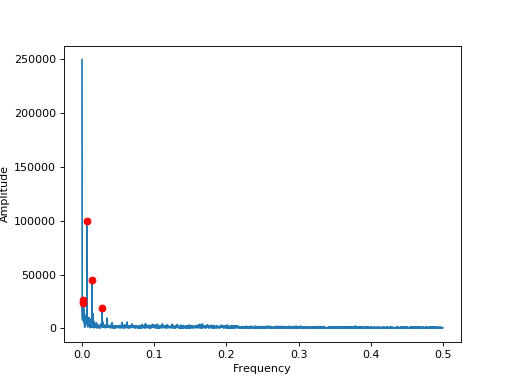

<IPython.core.display.Javascript object>


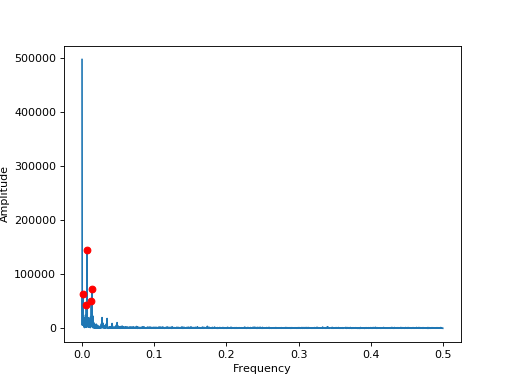

<IPython.core.display.Javascript object>


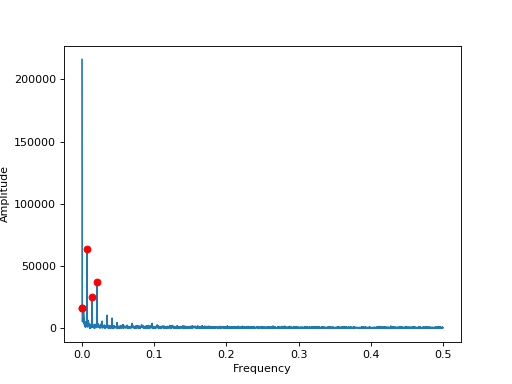

<IPython.core.display.Javascript object>


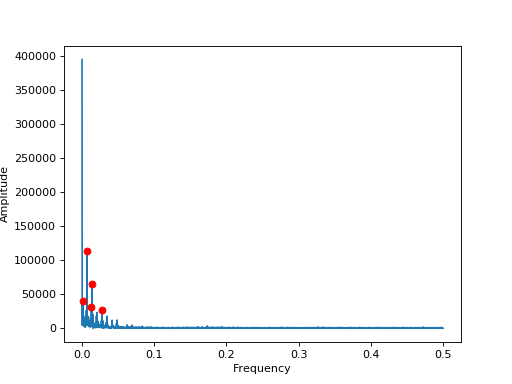

<IPython.core.display.Javascript object>


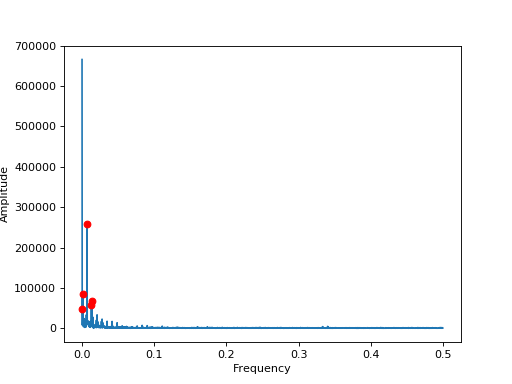

<IPython.core.display.Javascript object>


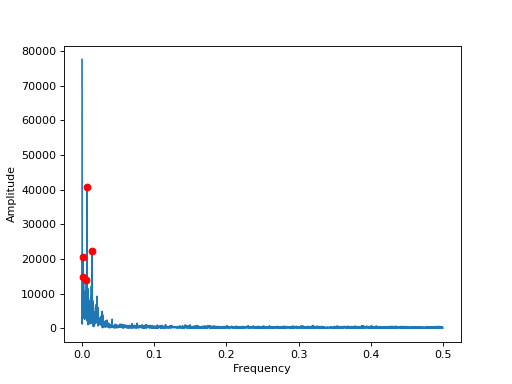

<IPython.core.display.Javascript object>


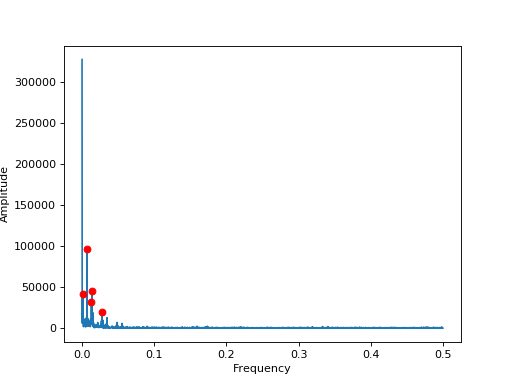

<IPython.core.display.Javascript object>


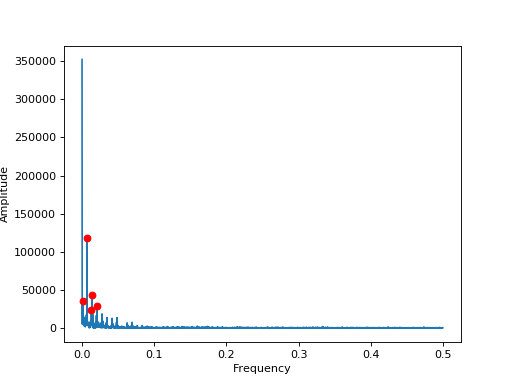

<IPython.core.display.Javascript object>


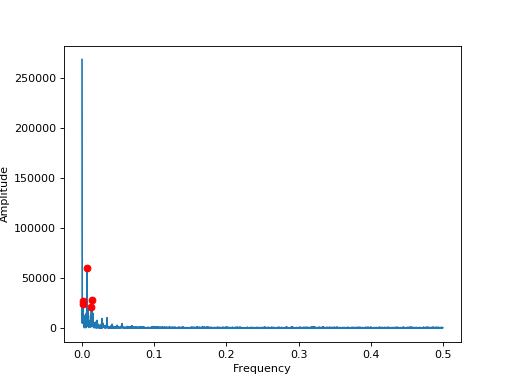

<IPython.core.display.Javascript object>


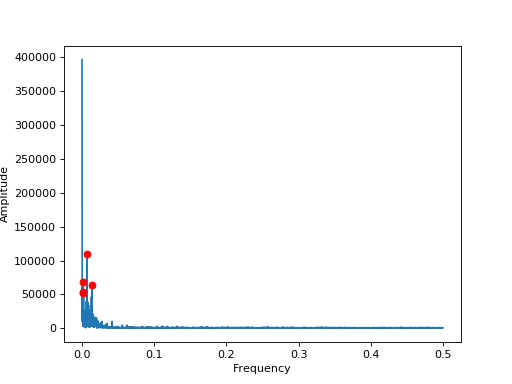

<IPython.core.display.Javascript object>


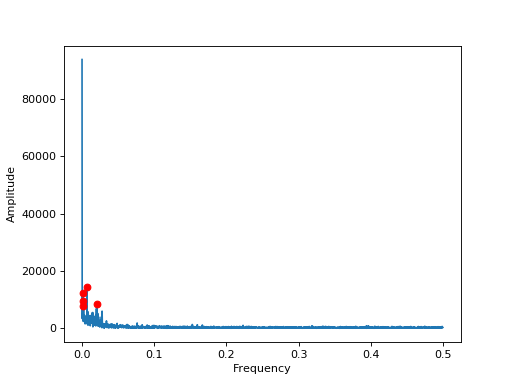

<IPython.core.display.Javascript object>


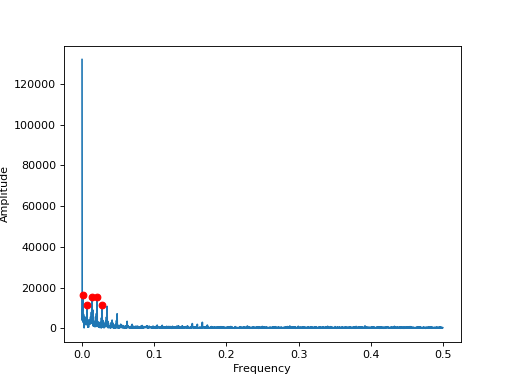

<IPython.core.display.Javascript object>


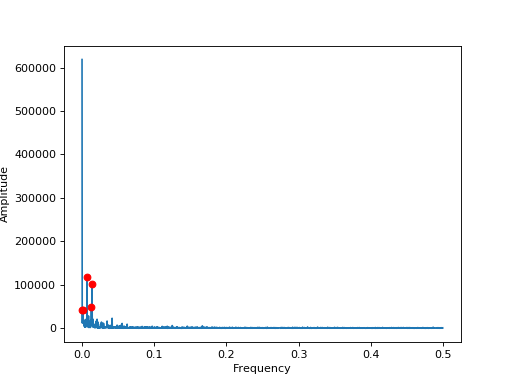

<IPython.core.display.Javascript object>


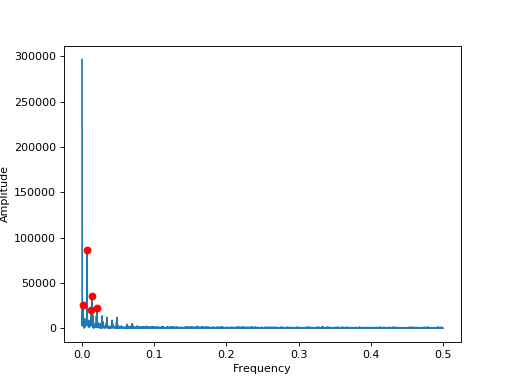

<IPython.core.display.Javascript object>


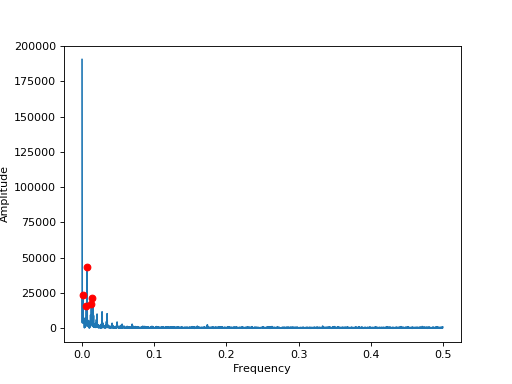

<IPython.core.display.Javascript object>


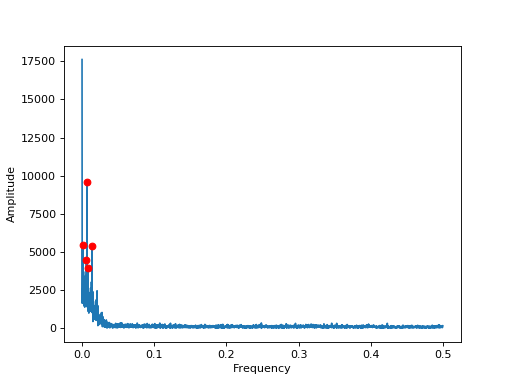

<IPython.core.display.Javascript object>


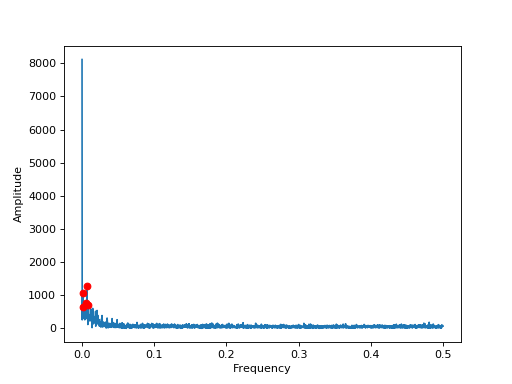

<IPython.core.display.Javascript object>


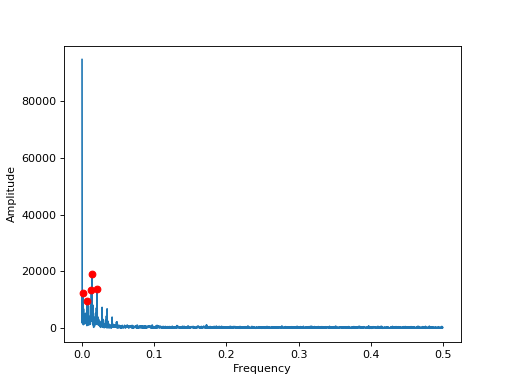

<IPython.core.display.Javascript object>


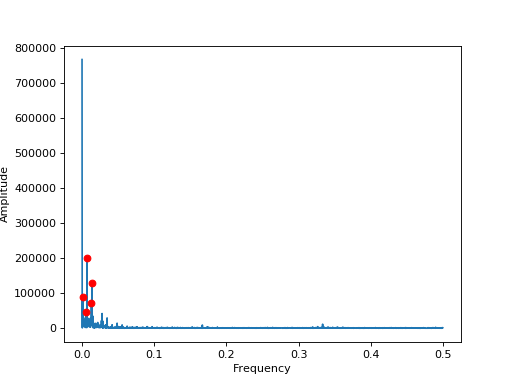

<IPython.core.display.Javascript object>


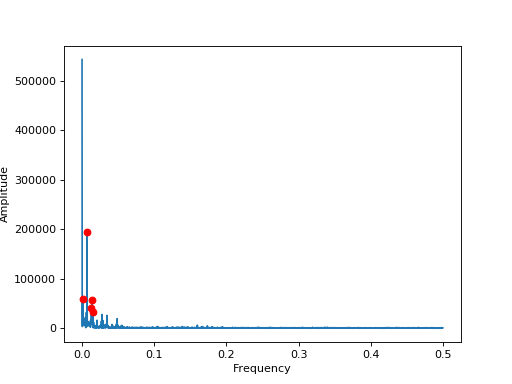

<IPython.core.display.Javascript object>


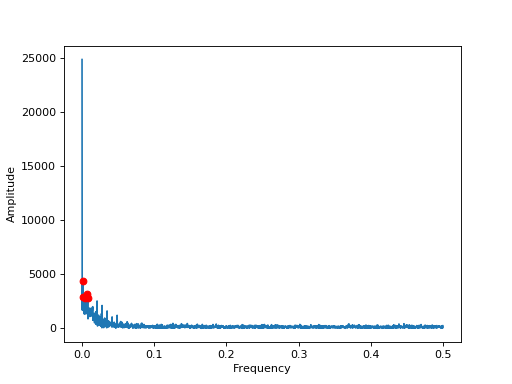

<IPython.core.display.Javascript object>


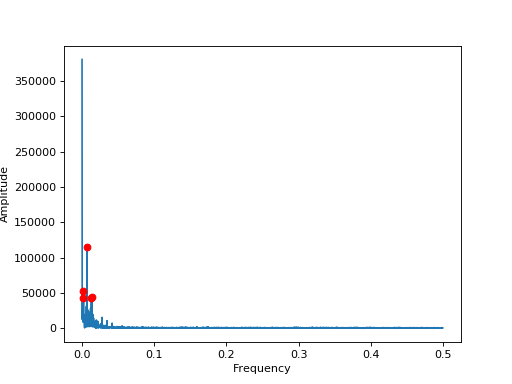

<IPython.core.display.Javascript object>


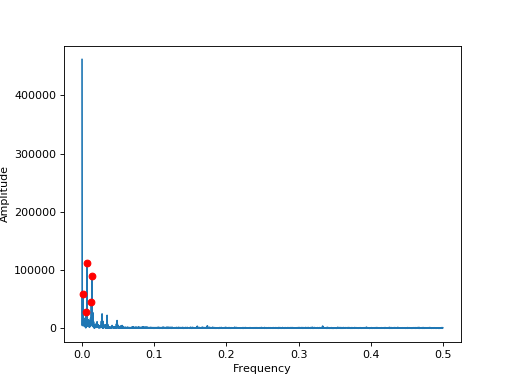

<IPython.core.display.Javascript object>


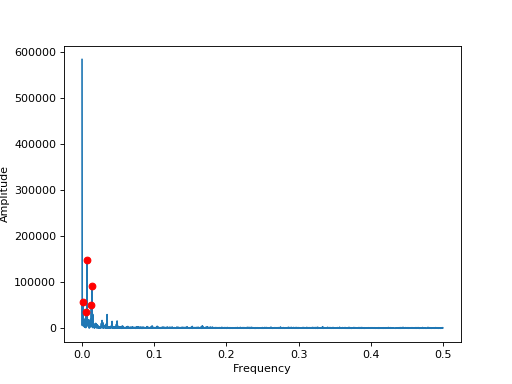

<IPython.core.display.Javascript object>


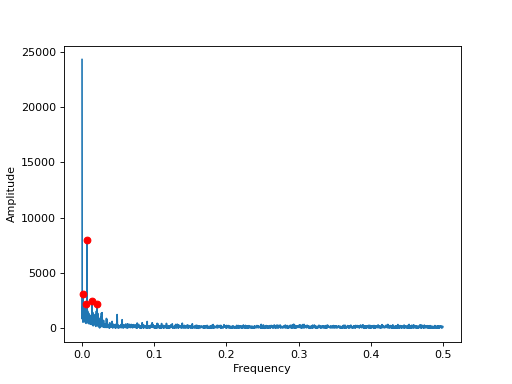

<IPython.core.display.Javascript object>


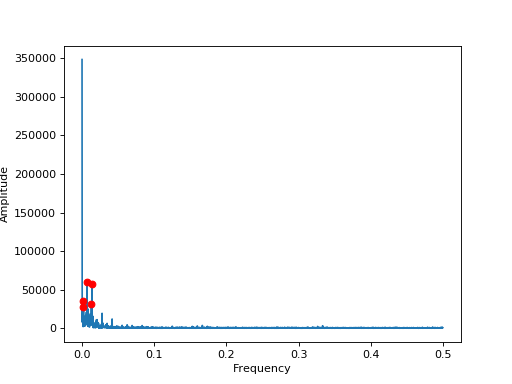

<IPython.core.display.Javascript object>


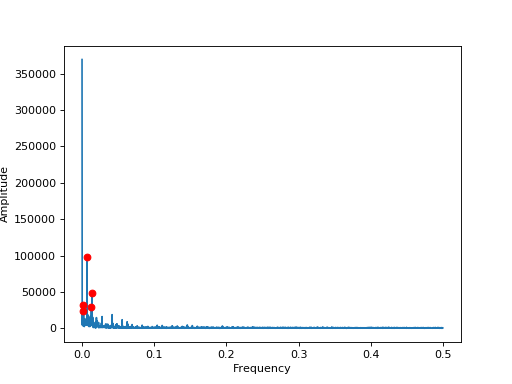

<IPython.core.display.Javascript object>


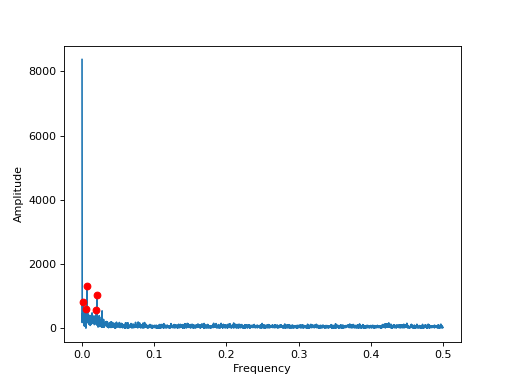

<IPython.core.display.Javascript object>


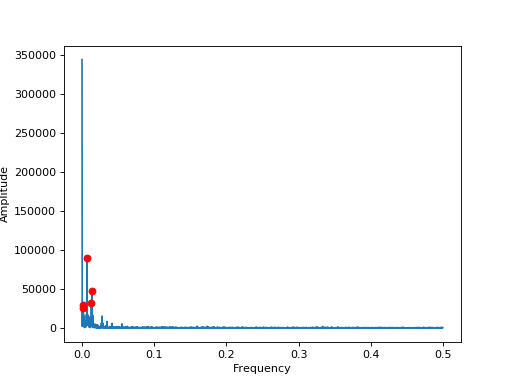

<IPython.core.display.Javascript object>


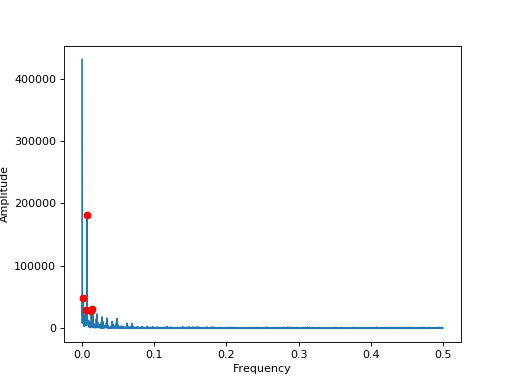

<IPython.core.display.Javascript object>


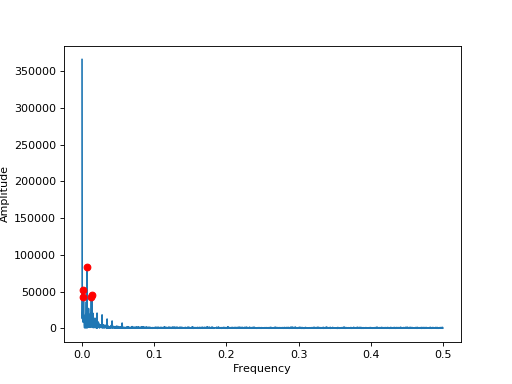

<IPython.core.display.Javascript object>


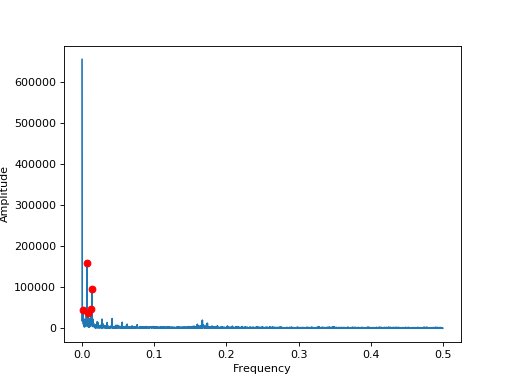

<IPython.core.display.Javascript object>


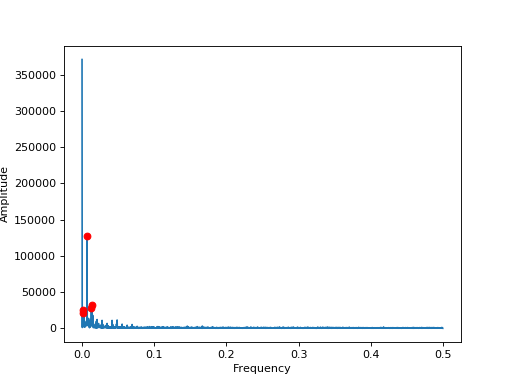

<IPython.core.display.Javascript object>


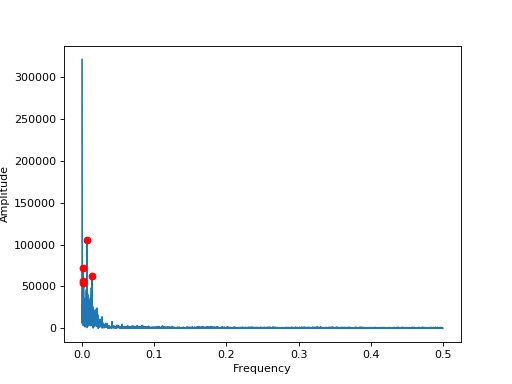

<IPython.core.display.Javascript object>


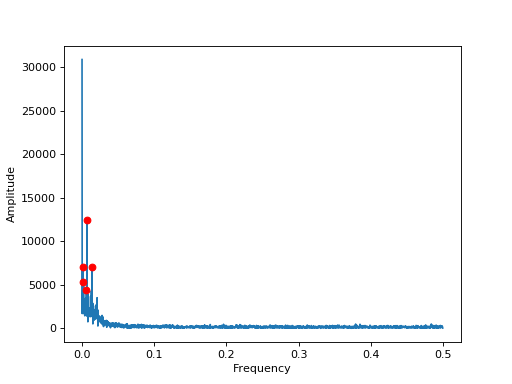

<IPython.core.display.Javascript object>


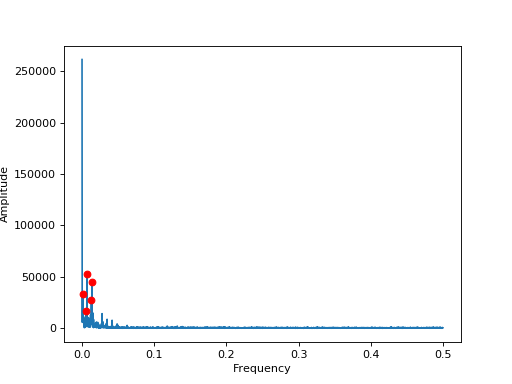

<IPython.core.display.Javascript object>


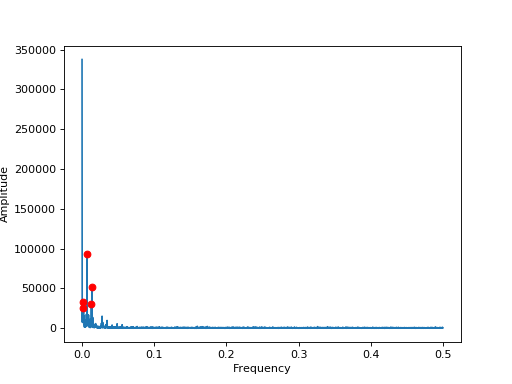

In [27]:
fft_features = []
for x in range(40):
    Y    = np.fft.fft(np.array(jan_2015_smooth[4464*x:4464*(x+1)]))
    freq = np.fft.fftfreq(4464)
    #peaks,d = sl.find_peaks(Y,height = 0 )
    #peaks = sl.argrelextrema(Y, np.greater)
    n = len(freq)
    plt.figure()
    d= { y:x for y,x in zip(np.abs(Y)[:int(n/2)],freq[:int(n/2)])  }
    plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
    amp = abs(np.array(sorted(np.abs(Y)[:int(n/2)])[-6:-1]))
    frq = abs(np.array([d[x] for x in abs(np.array(sorted(np.abs(Y)[:int(n/2)])[-6:-1]))]))
    plt.plot(frq , amp,'ro', label = 'peaks' )
    frq_amp = np.append(frq,amp)
    frq_amp = [x for x in frq_amp]
    fft_features.append(frq_amp)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

In [9]:
db['fft_features'] = fft_features

In [8]:
fft_features = db['fft_features']

In [8]:
len(fft_features)

40

In [9]:
len(fft_features[0])

10

In [13]:
db['kmeans']= kmeans

In [9]:
kmeans = db['kmeans']

In [10]:
number_of_time_stamps = 5
output = []
tsne_lat = []
tsne_lon = []
tsne_weekday = []
tsne_feature = []
tsne_fft_features = []

tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    #tsne_fft_features.append([fft_features[i]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [11]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [12]:
alpha=0.3
predicted_values=[]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

#### Exponential Weighted Moving Variance

In [13]:
alpha=0.3
predicted_values=[]
predicted_vars = []
predict_list1 = []
predict_list2 = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            predicted_var = 0
            continue
        predicted_vars.append(predicted_var)
        predicted_values.append(predicted_value)
        delta = regions_cum[r][i] - predicted_values[-1]
        predicted_value = predicted_values[-1]+alpha*delta
        #predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
        predicted_var = (1-alpha)*(predicted_vars[-1]+ alpha* (delta**2))
    predict_list1.append(predicted_vars[4:])
    predict_list2.append([math.sqrt(x) for x in predicted_vars[4:]])
    predicted_values=[]
    predicted_vars = []

#### Double Exponential Smoothing

In [94]:
alpha=0.3
beta = 0.3
predicted_values=[]
predicted_trends = []
predict_list3 = []
predict_list4 = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            continue
        if i==1:
            predicted_value= regions_cum[r][1]
            predicted_trend = regions_cum[r][1]-regions_cum[r][0]
            continue
        predicted_trends.append(predicted_trend)
        predicted_values.append(predicted_value)
        predicted_value = alpha*regions_cum[r][i]+(1-alpha)*(predicted_value+predicted_trend)
        predicted_trend = beta*(predicted_value - predicted_values[-1])+(1-beta)*predicted_trend
    predict_list3.append(predicted_values[3:])
    predict_list4.append(predicted_trends[3:])
    predicted_values=[]
    predicted_trends = []

In [86]:
print(len(predict_list3[0]))
print(len(predict_list4[0]))

13099
13099


#### Triple Exponential Smoothing

In [113]:
alpha=0.3
beta = 0.3
gamma = 0.3
predicted_values=[]
predicted_trends = []
predicted_seasons = []
predict_list5 = []
predict_list6 = []
predict_list7 = []
for r in range(0,40):
    for i in range(0,13104):
        if i<144:
            predicted_season = (regions_cum[r][i]/(sum(regions_cum[r][:144])/144))+gamma
            #print(predicted_season)
            predicted_seasons.append(predicted_season)
            predicted_values.append(0)
            predicted_trends.append(0)
            continue
        if i == 144:
            predicted_value = regions_cum[r][i]/np.round(predicted_seasons[i-144],3)
            predicted_trend = predicted_value - regions_cum[r][i-1]/predicted_seasons[-1]
            predicted_season = gamma*(regions_cum[r][i]/predicted_value)+(1-gamma)*predicted_seasons[i-144]
            predicted_values.append(predicted_value)
            predicted_trends.append(predicted_trend)
            predicted_seasons.append(predicted_season)
            #print(predicted_value,predicted_trend,predicted_season)
            continue
        predicted_value = alpha*(regions_cum[r][i]+(1-alpha)/predicted_seasons[i-144])+(1-alpha)*(predicted_value+predicted_trend)
        predicted_trend = beta*(predicted_value - predicted_values[i-1])+(1-beta)*predicted_trend
        predicted_season = gamma*(regions_cum[r][i]/predicted_value)+(1-gamma)*predicted_seasons[i-144]
        predicted_values.append(predicted_value)
        predicted_trends.append(predicted_trend)
        predicted_seasons.append(predicted_season)
    predict_list5.append(predicted_values[5:])
    predict_list6.append(predicted_trends[5:])
    predict_list7.append(predicted_seasons[5:])
    predicted_values=[]
    predicted_trends = []
    predicted_seasons = []

In [98]:
print(len(predict_list5[0]))
print(len(predict_list6[0]))
print(len(predict_list7[0]))

13099
13099
13099


In [14]:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [15]:
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [16]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [114]:
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]
tsne_train_flat_exp_var = [i[:9169] for i in predict_list1]
tsne_train_flat_exp_std = [i[:9169] for i in predict_list2]
tsne_train_flat_exp_double = [i[:9169] for i in predict_list3]
tsne_train_flat_exp_trend = [i[:9169] for i in predict_list4]
tsne_train_flat_exp_triple = [i[:9169] for i in predict_list5]
tsne_train_flat_exp_trend1 = [i[:9169] for i in predict_list6]
tsne_train_flat_exp_season1 = [i[:9169] for i in predict_list7]
#tsne_train_flat_fft = [i[:9169] for i in tsne_fft_features]

In [115]:
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]
tsne_test_flat_exp_var = [i[9169:] for i in predict_list1]
tsne_test_flat_exp_std = [i[9169:] for i in predict_list2]
tsne_test_flat_exp_double = [i[9169:] for i in predict_list3]
tsne_test_flat_exp_trend = [i[9169:] for i in predict_list4]
tsne_test_flat_exp_triple = [i[9169:] for i in predict_list5]
tsne_test_flat_exp_trend1 = [i[9169:] for i in predict_list6]
tsne_test_flat_exp_season1 = [i[9169:] for i in predict_list7]
#tsne_test_flat_fft = [i[9169:] for i in tsne_fft_features]

In [19]:
len(train_features[0][0])

5

In [20]:
len(train_features[0])

9169

In [21]:
train_new_features = []
for i in range(0,40):
    #train_new_features.extend(np.append(train_features[i],tsne_train_flat_fft[i],axis=1))
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    #test_new_features.extend(np.append(test_features[i],tsne_test_flat_fft[i],axis=1))
    test_new_features.extend(test_features[i])

In [22]:
print(len(train_new_features))
print(len(test_new_features))

366760
157200


In [116]:
tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])
tsne_train_exp_var = sum(tsne_train_flat_exp_var,[])
tsne_train_exp_std = sum(tsne_train_flat_exp_std,[])
tsne_train_exp_double = sum(tsne_train_flat_exp_double,[])
tsne_train_exp_trend = sum(tsne_train_flat_exp_trend,[])
tsne_train_exp_triple = sum(tsne_train_flat_exp_triple,[])
tsne_train_exp_trend1 = sum(tsne_train_flat_exp_trend1,[])
tsne_train_exp_season1 = sum(tsne_train_flat_exp_season1,[])

In [117]:
tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])
tsne_test_exp_var = sum(tsne_test_flat_exp_var,[])
tsne_test_exp_std = sum(tsne_test_flat_exp_std,[])
tsne_test_exp_double = sum(tsne_test_flat_exp_double,[])
tsne_test_exp_trend = sum(tsne_test_flat_exp_trend,[])
tsne_test_exp_triple = sum(tsne_test_flat_exp_triple,[])
tsne_test_exp_trend1 = sum(tsne_test_flat_exp_trend1,[])
tsne_test_exp_season1 = sum(tsne_test_flat_exp_season1,[])

In [25]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg
print(df_train.shape)

(366760, 9)


In [159]:
db['df_train'] = df_train

In [160]:
db['tsne_train_output'] = tsne_train_output

In [168]:
len(tsne_test_flat_exp_var[0])

3930

In [26]:
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
#df_test['exp_var'] = tsne_test_exp_var
#df_test['exp_std'] = tsne_test_exp_std
print(df_test.shape)

(157200, 9)


In [170]:
db['df_test'] = df_test

In [171]:
db['tsen_test_output'] = tsne_test_output

In [27]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0   118   106   104    93   102  40.776228 -73.982119        4      100
1   106   104    93   102   101  40.776228 -73.982119        4      100
2   104    93   102   101   120  40.776228 -73.982119        4      114
3    93   102   101   120   131  40.776228 -73.982119        4      125
4   102   101   120   131   164  40.776228 -73.982119        4      152

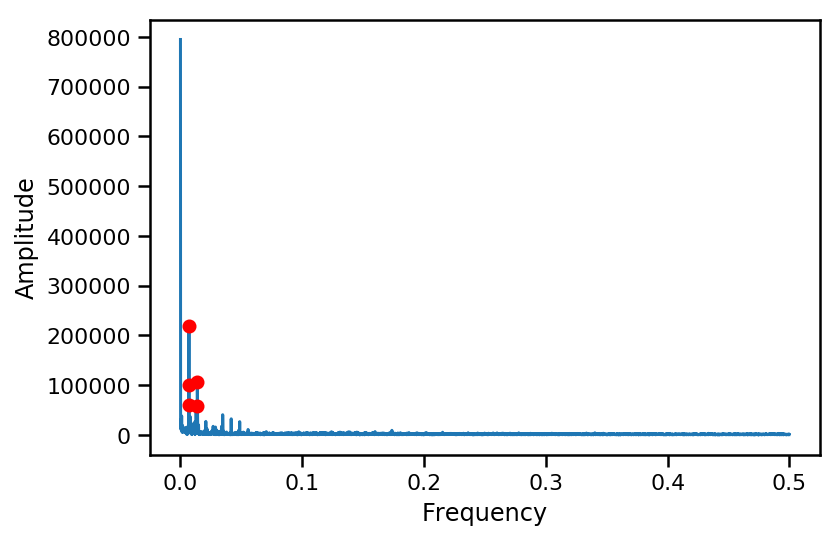

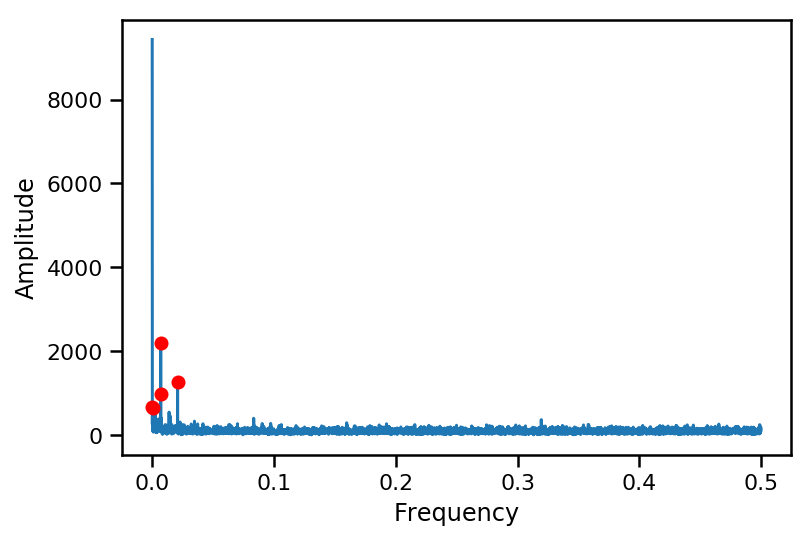

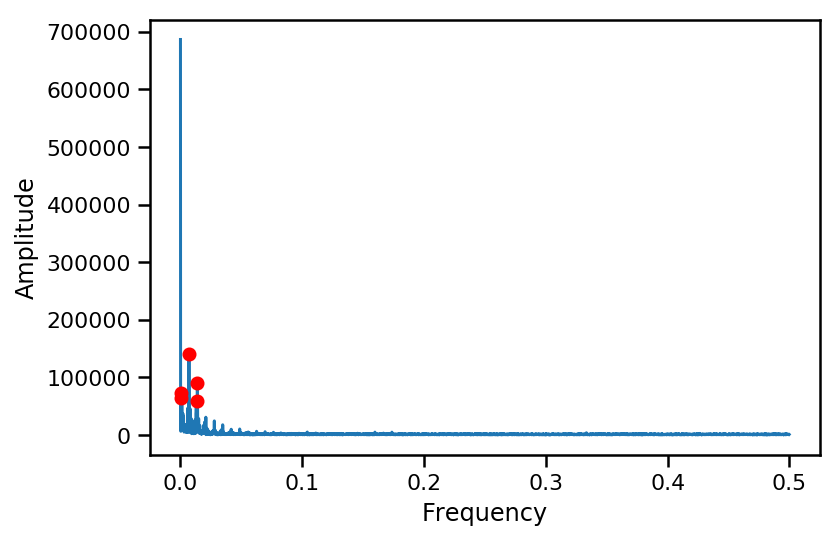

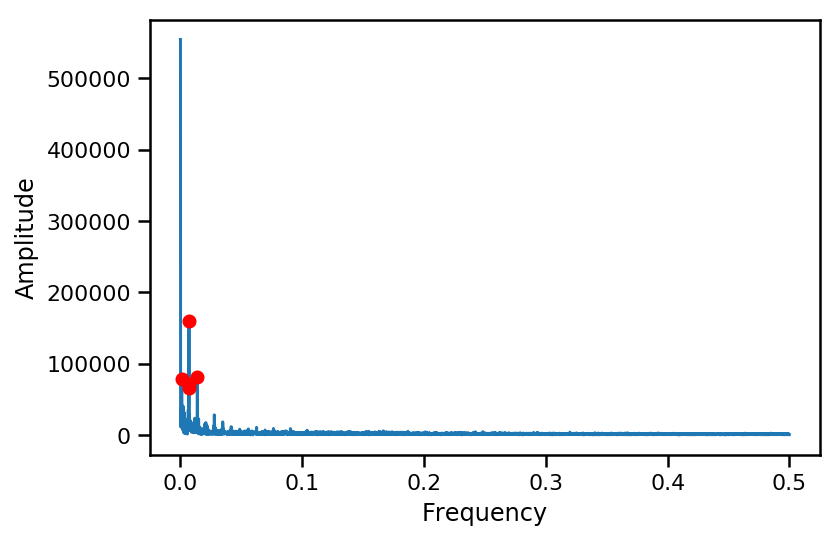

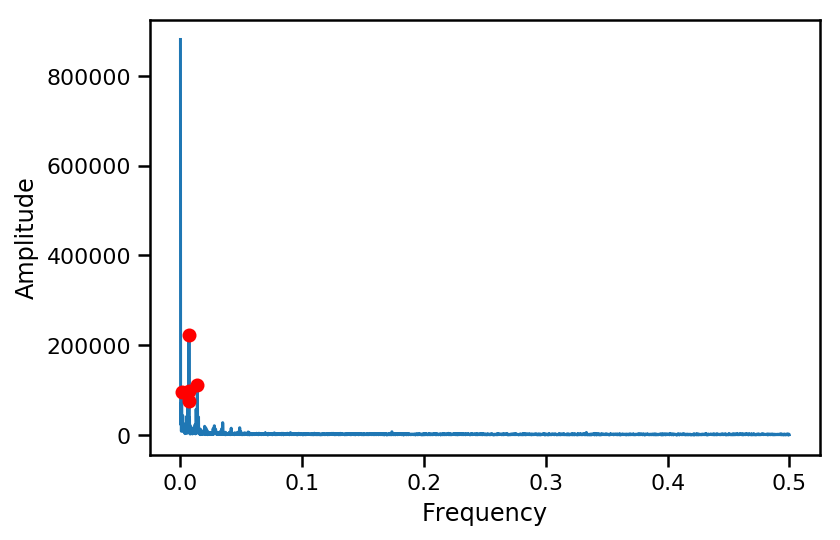

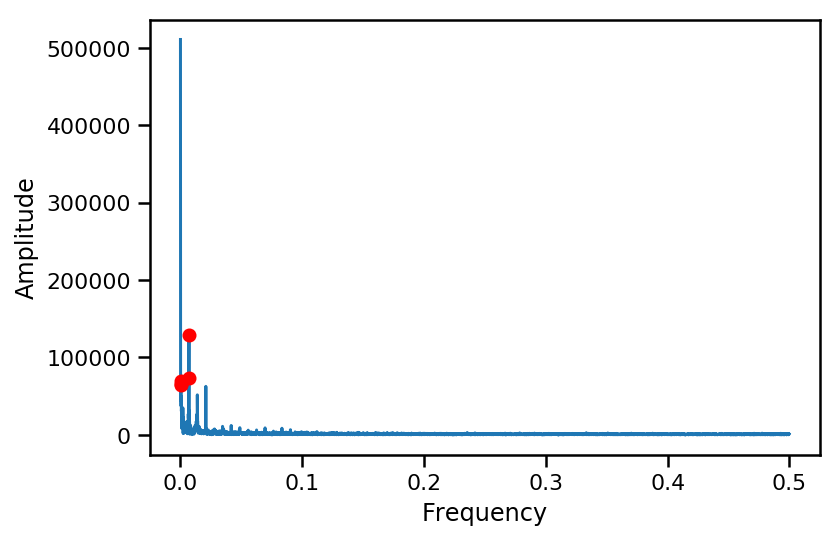

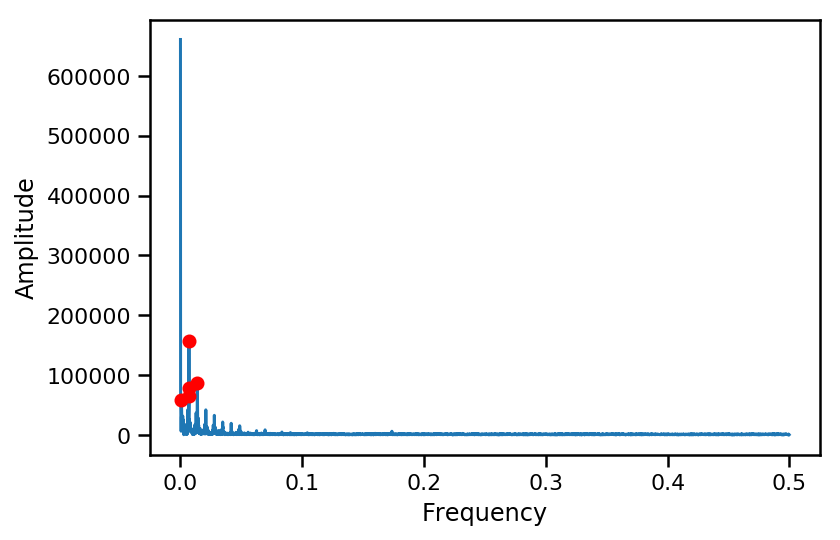

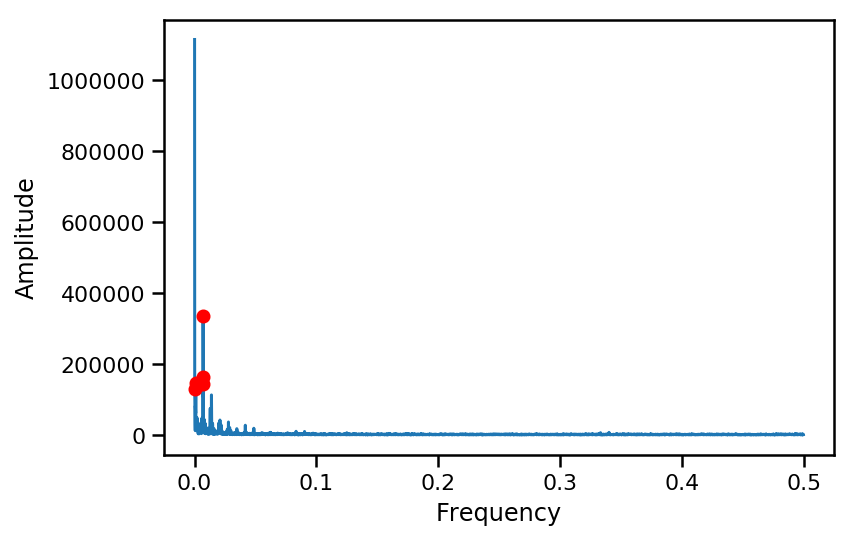

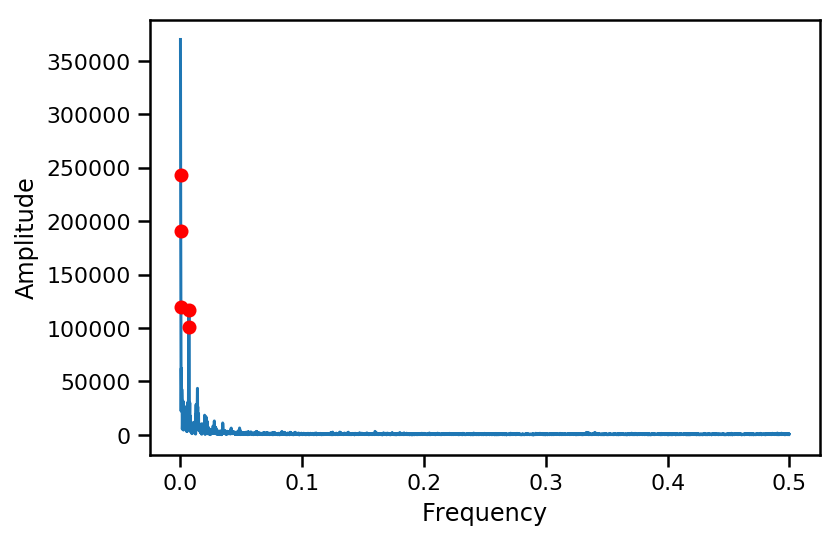

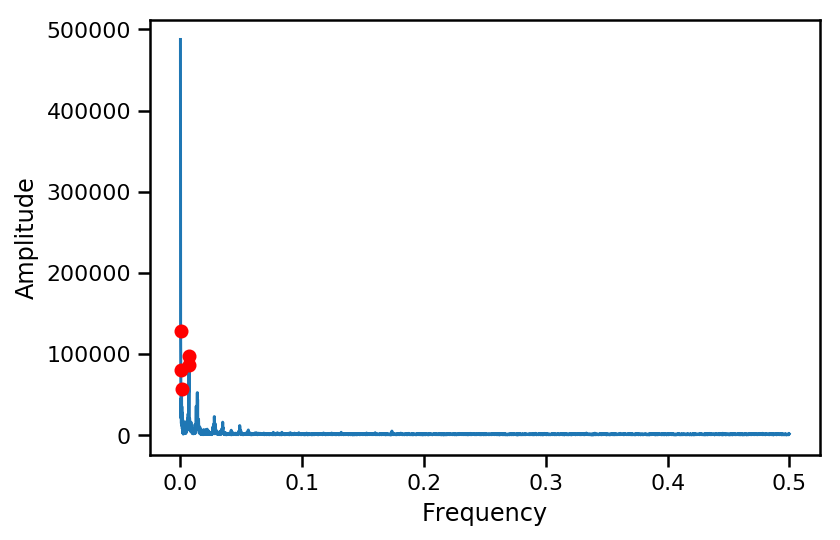

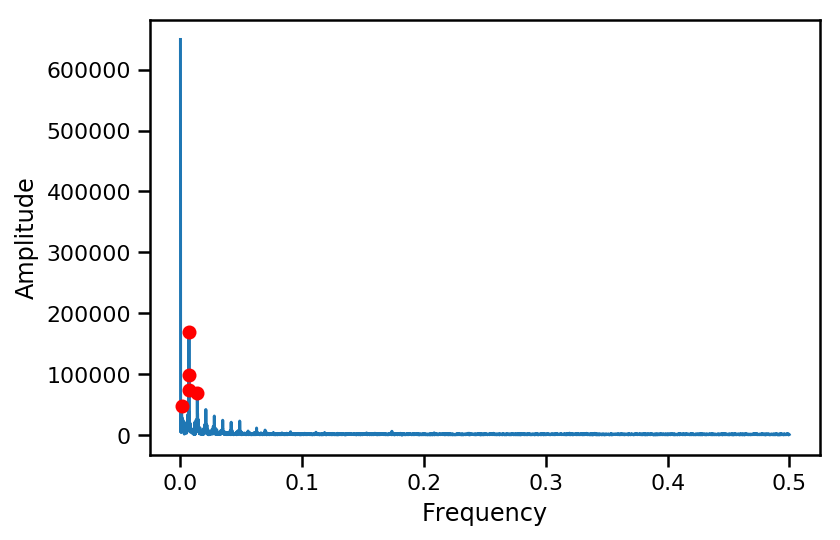

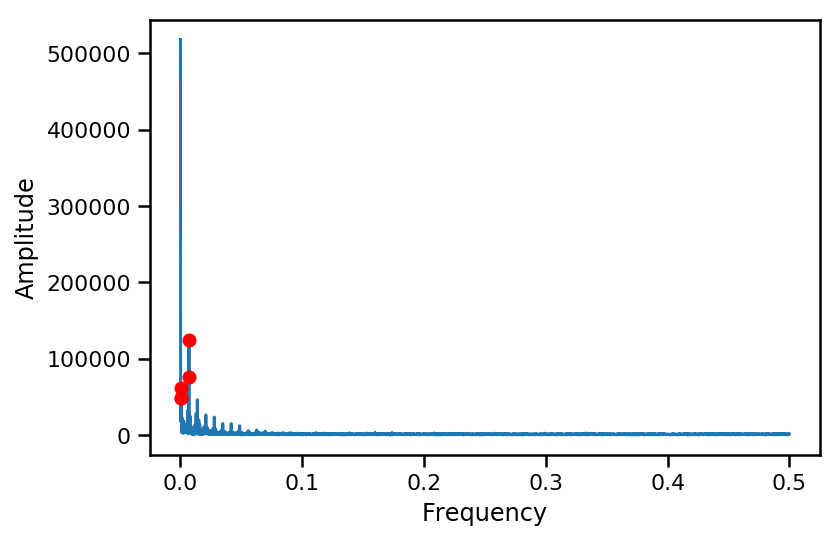

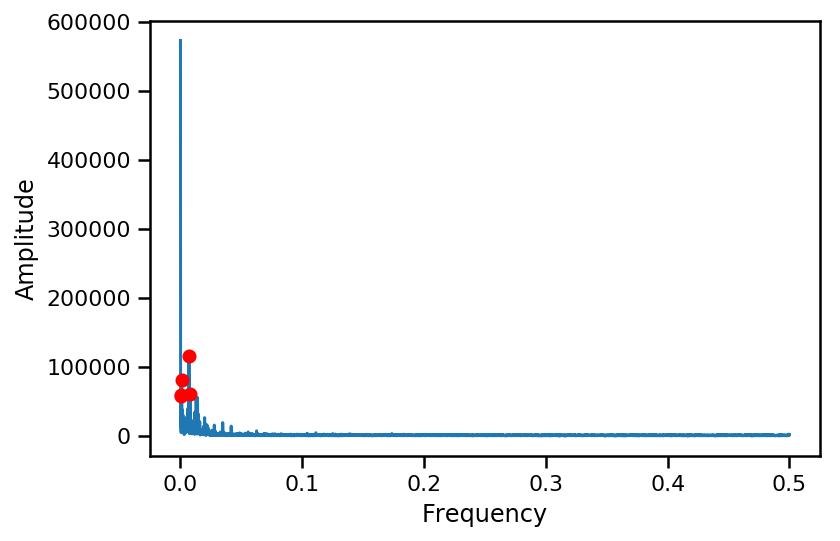

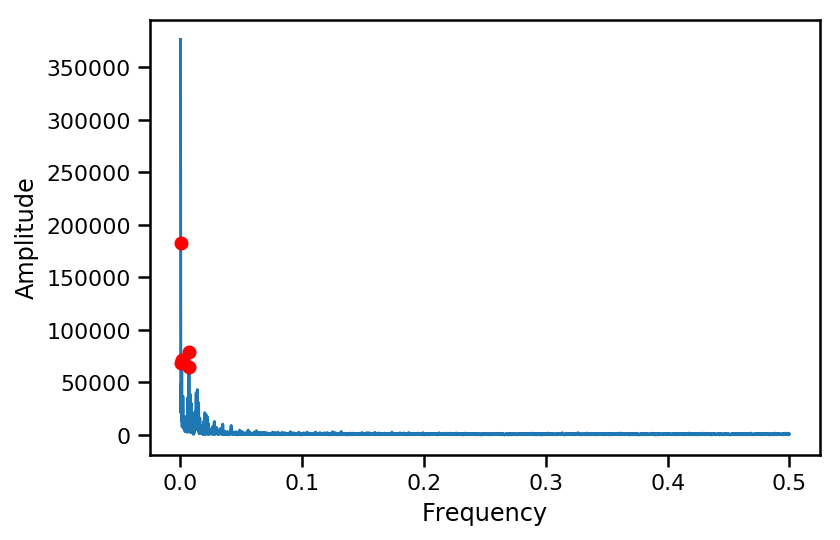

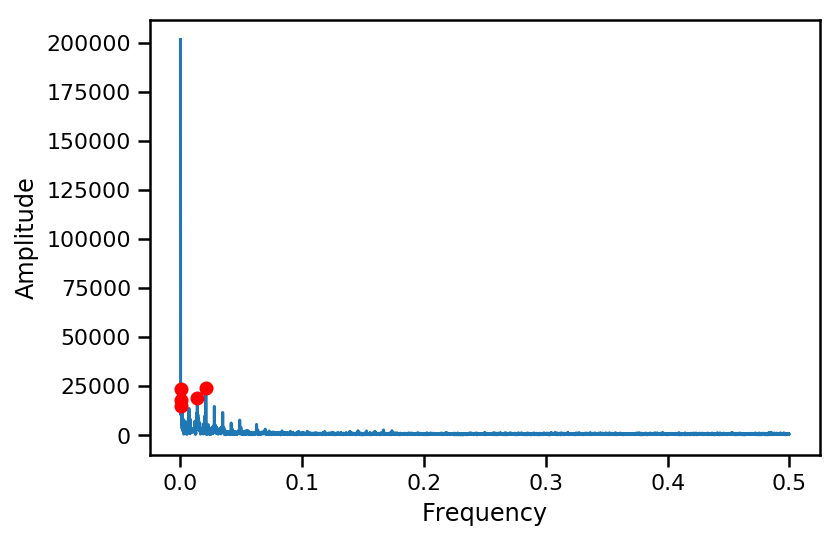

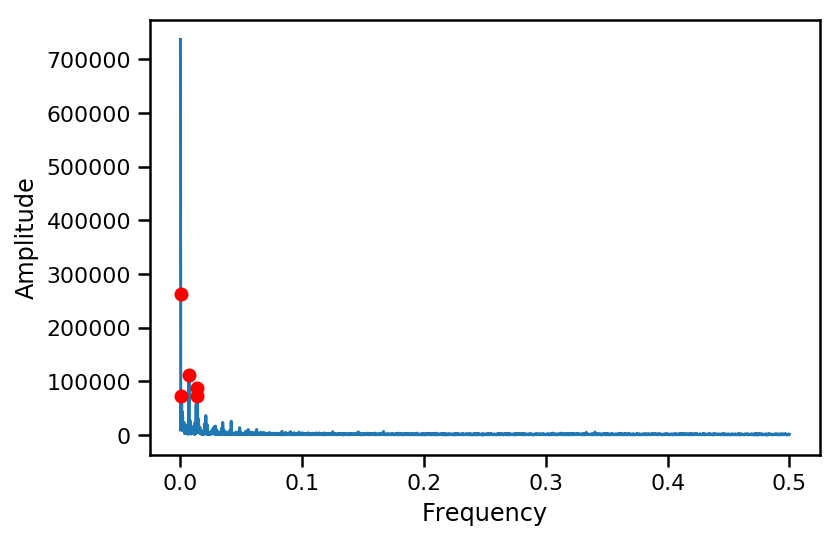

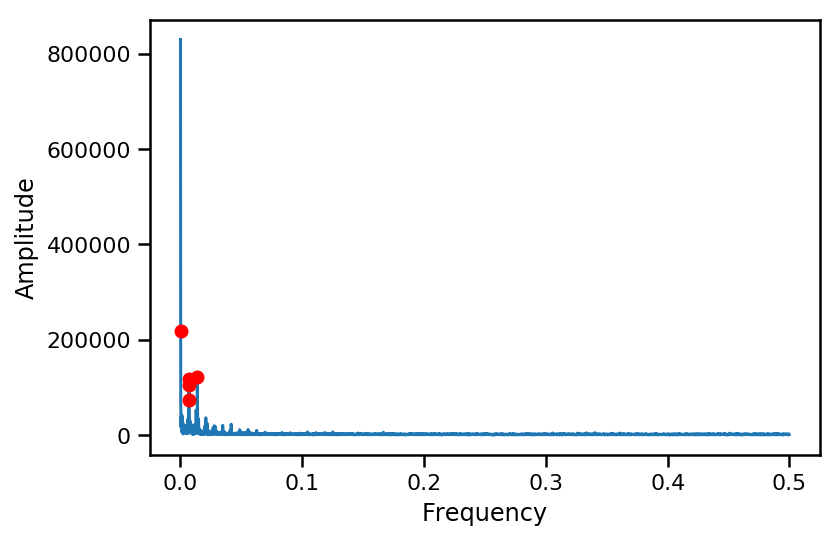

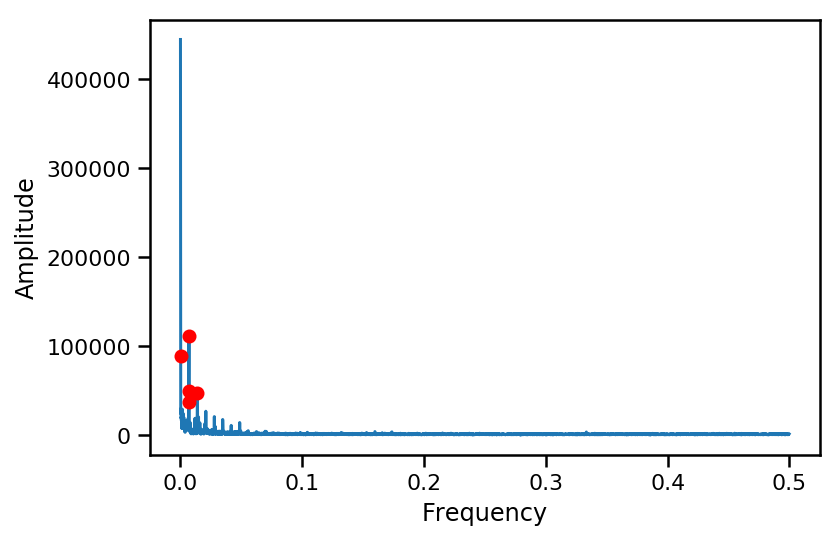

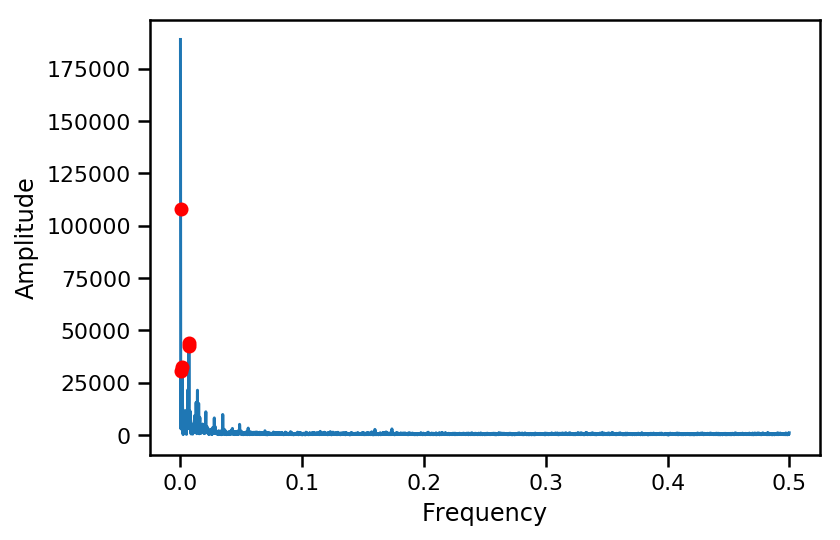

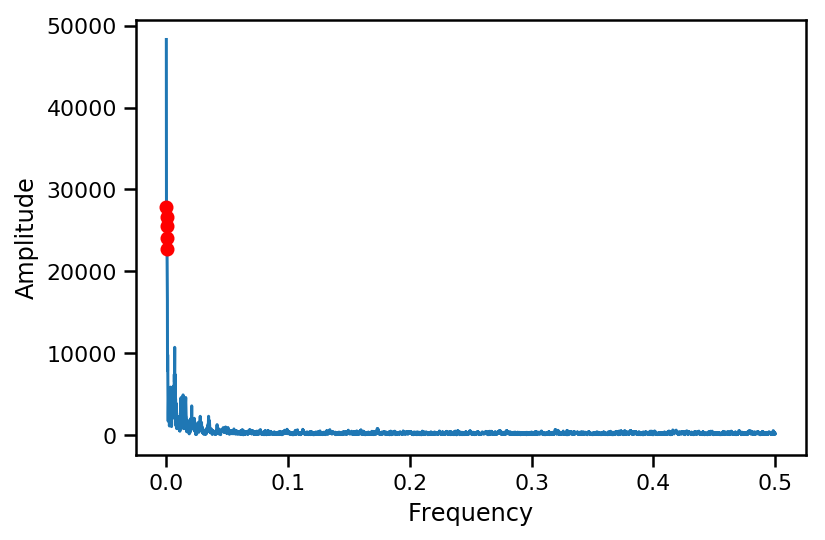

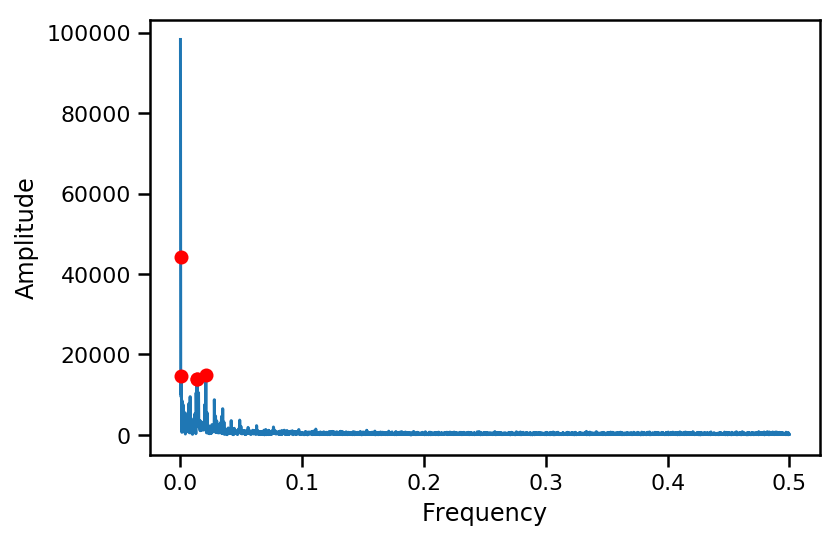

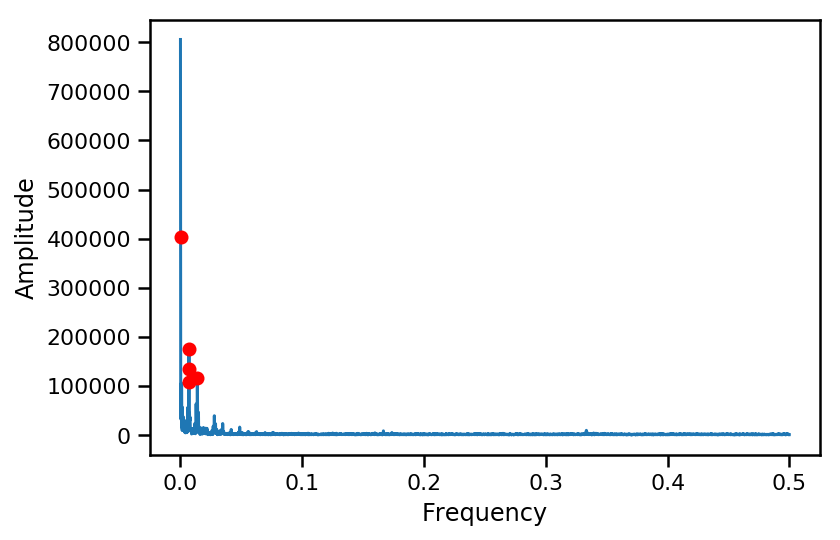

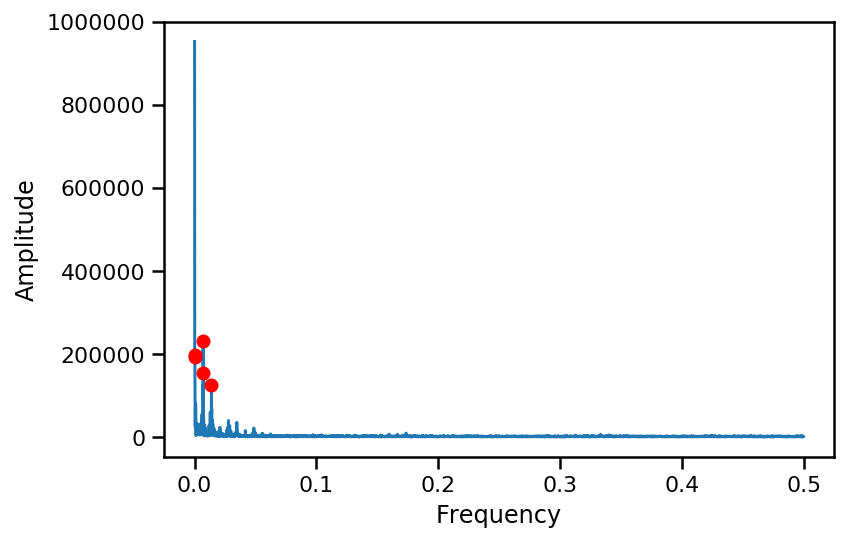

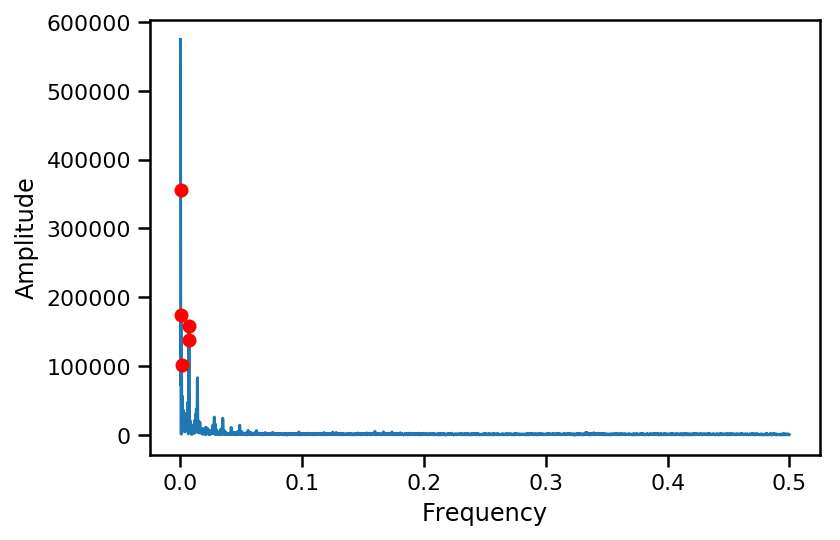

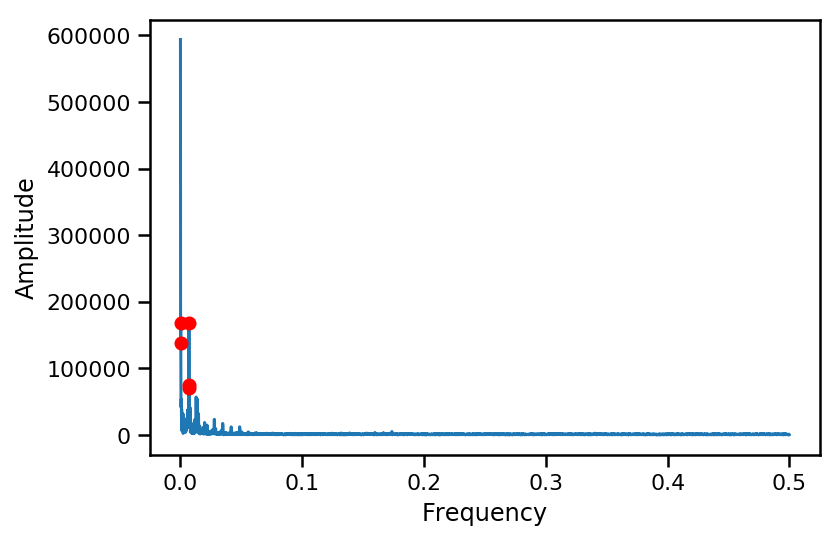

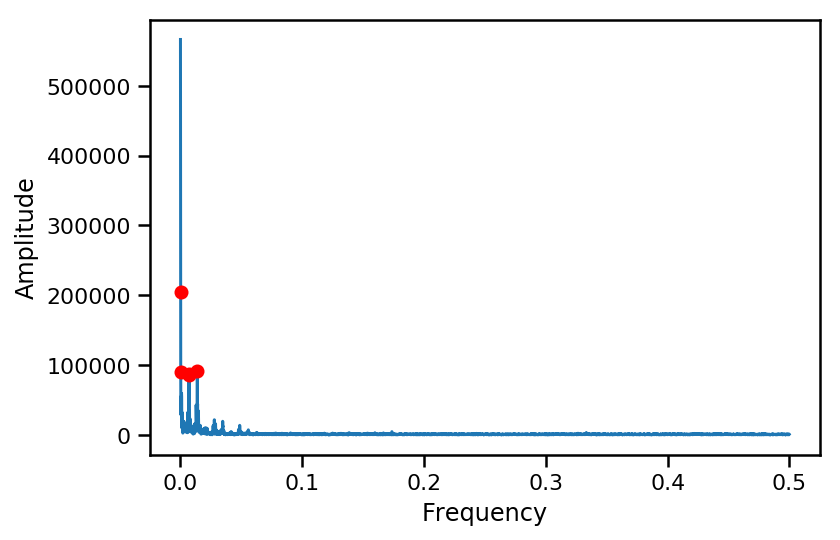

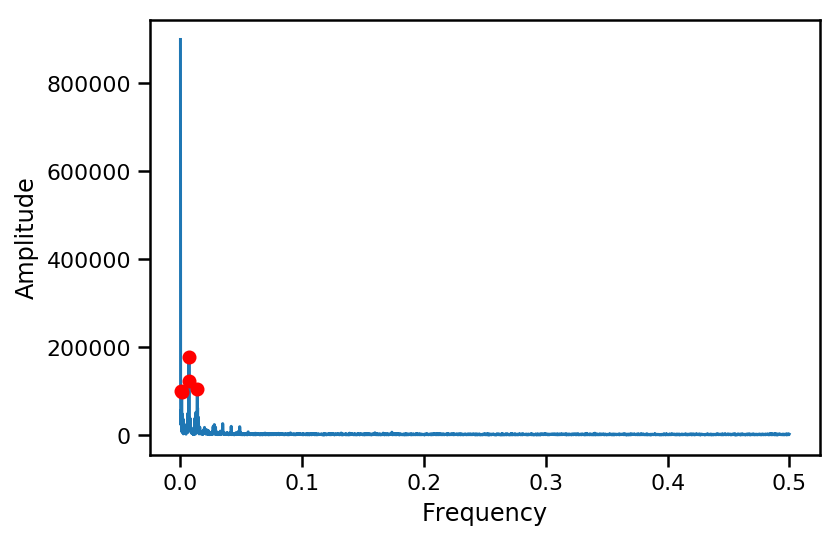

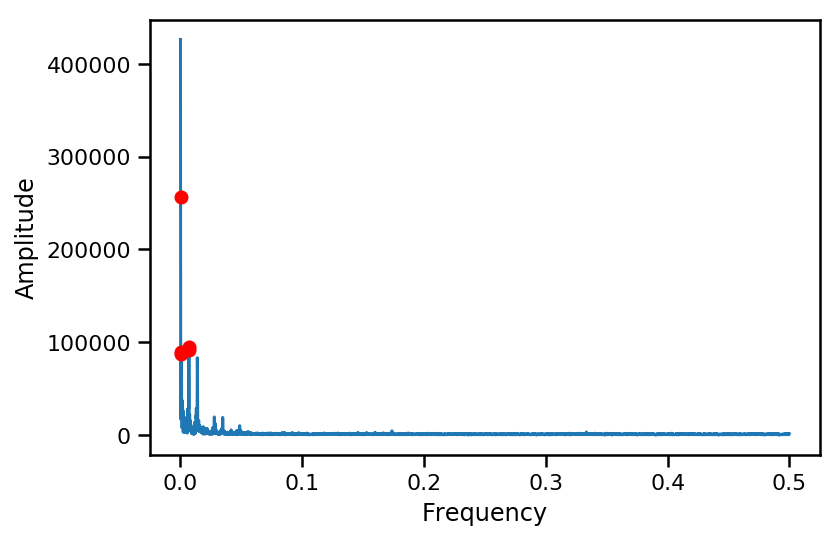

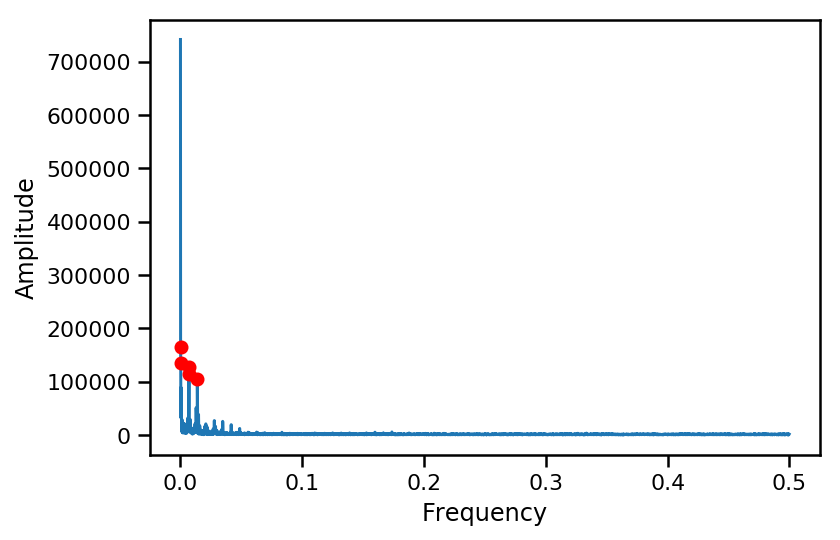

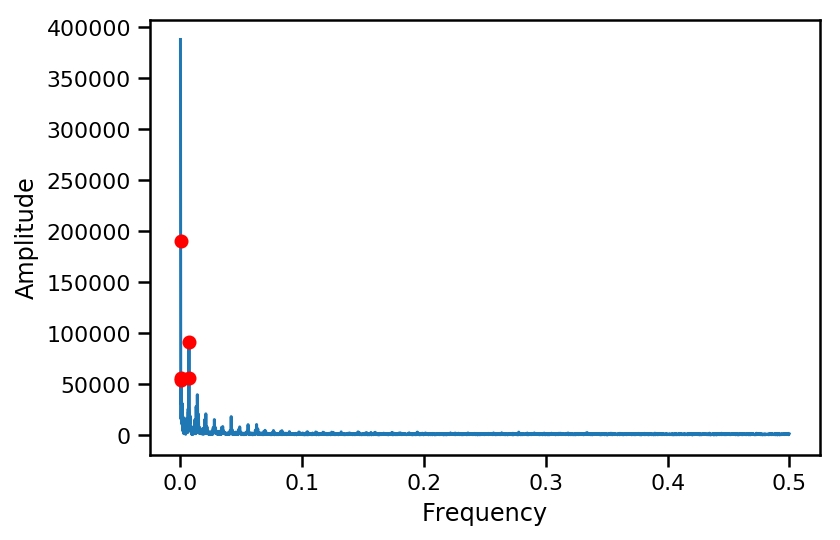

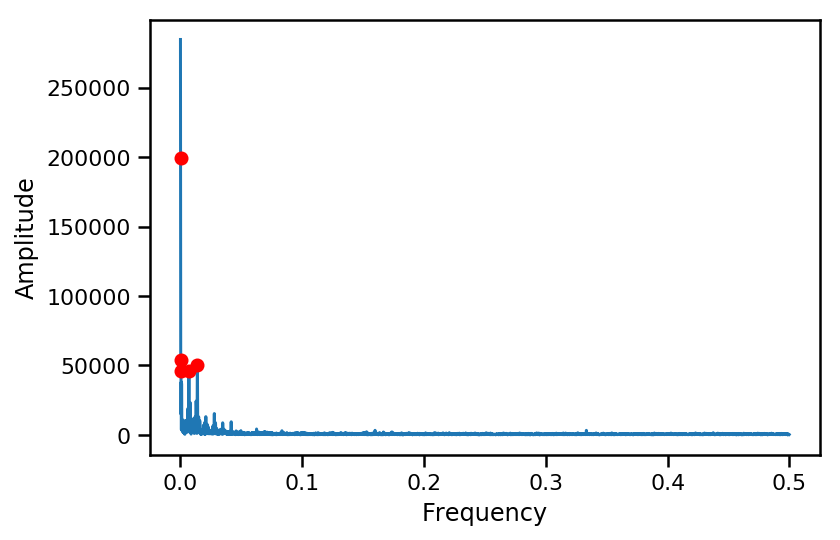

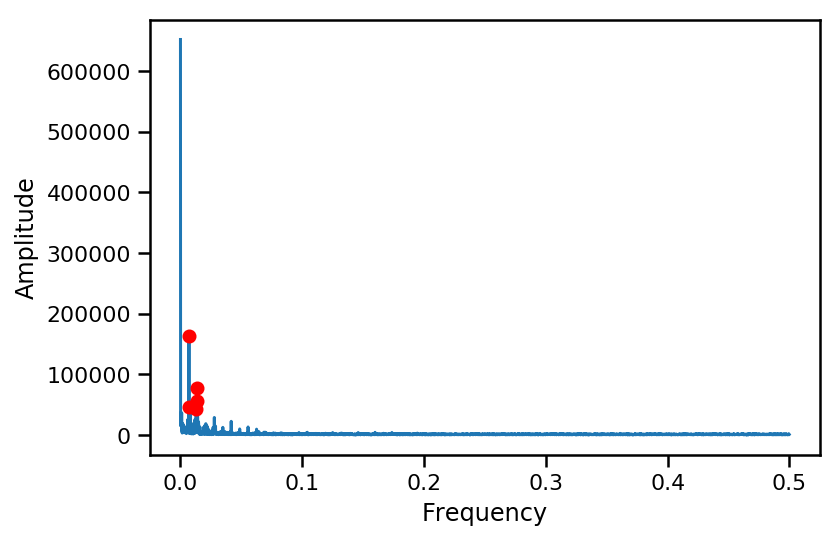

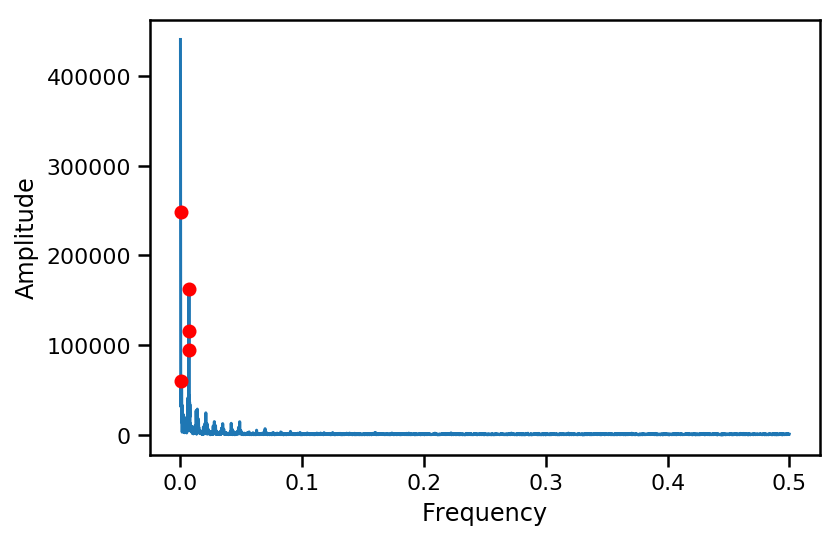

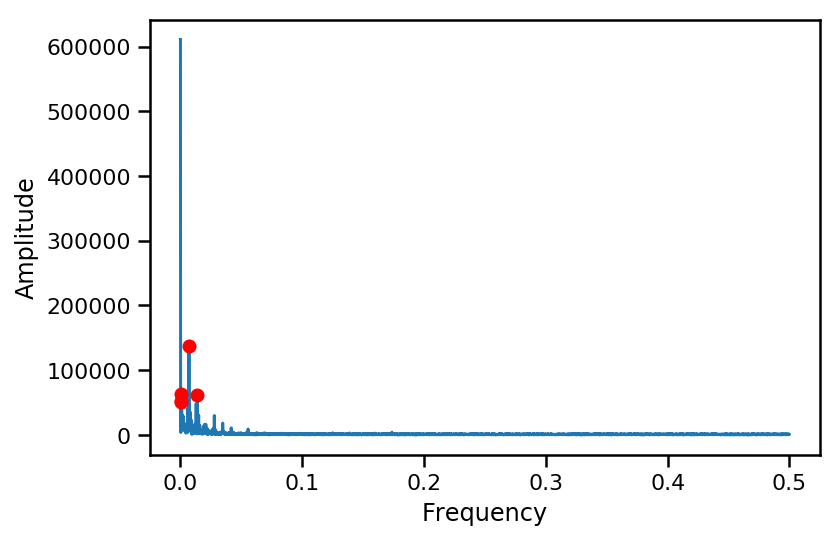

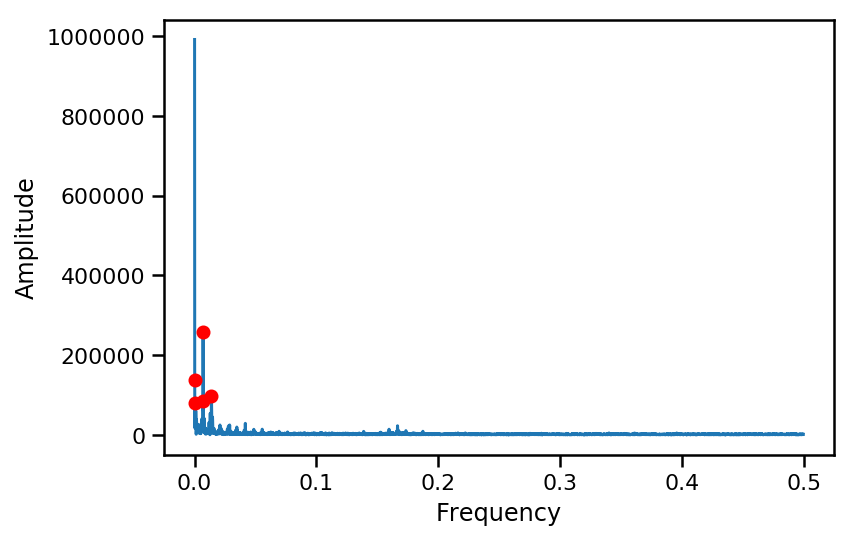

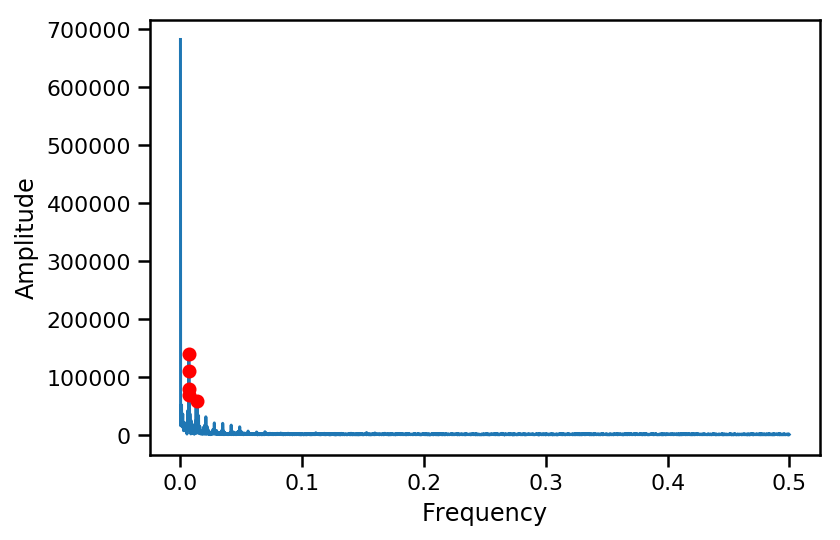

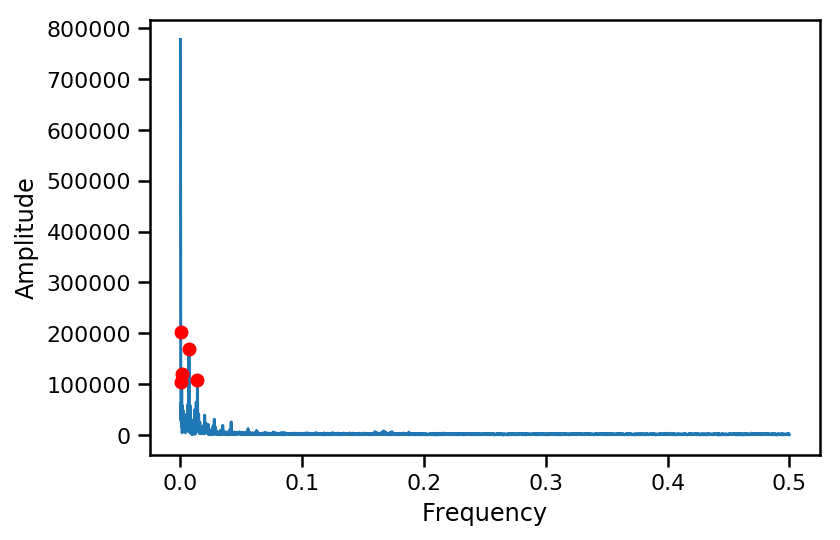

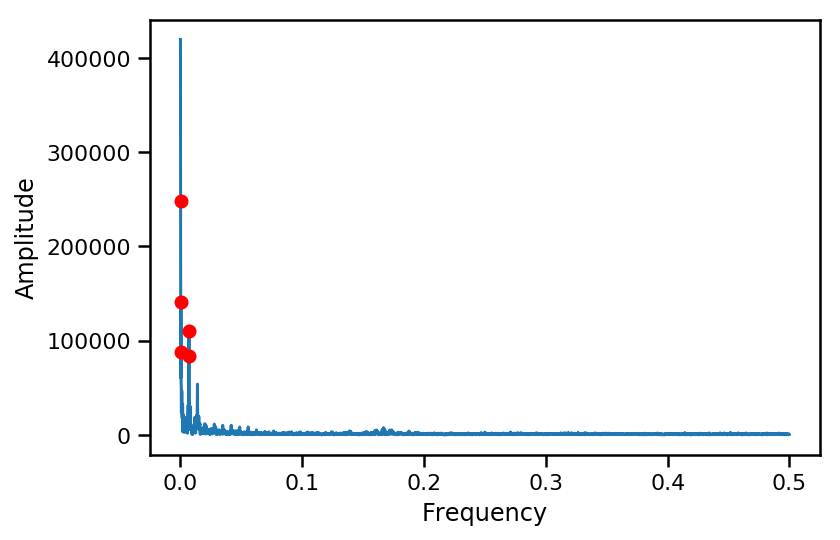

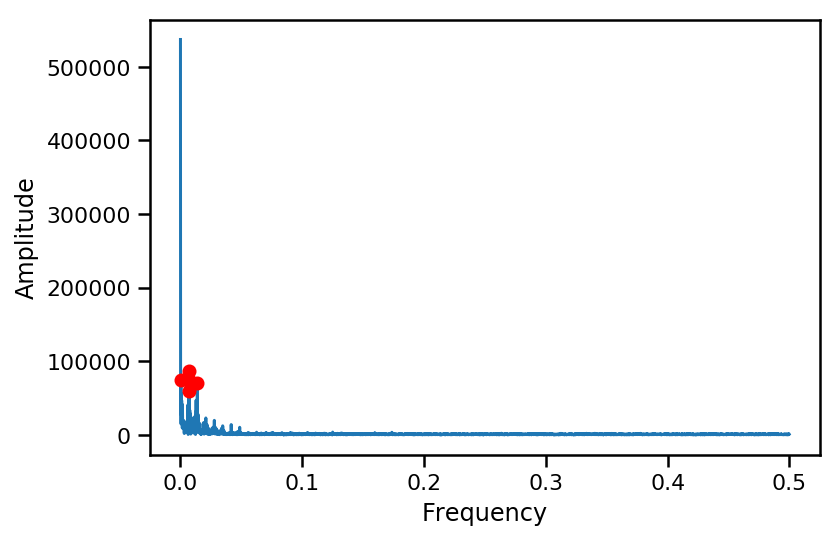

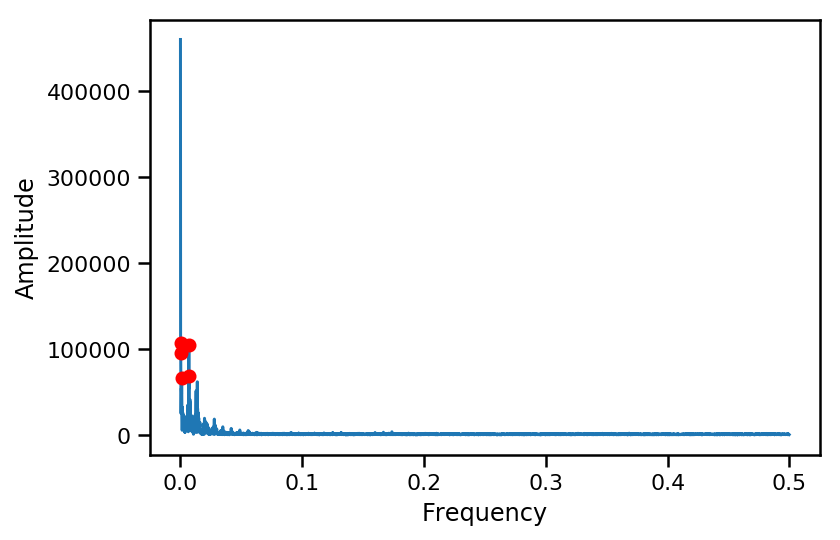

In [32]:
fft_features = []
for x in range(40):
    Y    = np.fft.fft(np.array(tsne_train_output[9169*x:9169*(x+1)]))
    freq = np.fft.fftfreq(9169)
    #peaks,d = sl.find_peaks(Y,height = 0 )
    #peaks = sl.argrelextrema(Y, np.greater)
    n = len(freq)
    plt.figure()
    d= { y:x for y,x in zip(np.abs(Y)[:int(n/2)],freq[:int(n/2)])  }
    plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
    amp = abs(np.array(sorted(np.abs(Y)[:int(n/2)])[-6:-1]))
    frq = abs(np.array([d[x] for x in abs(np.array(sorted(np.abs(Y)[:int(n/2)])[-6:-1]))]))
    plt.plot(frq , amp,'ro', label = 'peaks' )
    frq_amp = np.append(frq,amp)
    frq_amp = [x for x in frq_amp]
    fft_features.append(frq_amp)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

In [38]:
columns = ['fr1','fr2','fr3','fr4','fr5','amp1','amp2','amp3','amp4','amp5']
fft_train_features = []
fft_test_features = []
for fft in fft_features:
    fft_train_features.append(np.array(fft*9169).reshape(9169,10))
    fft_test_features.append(np.array(fft*3930).reshape(3930,10))
fft_train_features = np.asarray(fft_train_features).reshape(366760,10)
fft_test_features = np.asarray(fft_test_features).reshape(157200,10)

In [39]:
fft_train_features = pd.DataFrame(fft_train_features,columns = columns)
fft_test_features = pd.DataFrame(fft_test_features,columns = columns)

In [40]:
print(fft_train_features.shape)
print(fft_test_features.shape)

(366760, 10)
(157200, 10)


In [41]:
df_train_new = pd.concat([df_train,fft_train_features],axis = 1)
df_test_new = pd.concat([df_test,fft_test_features],axis = 1)

In [42]:
print(df_train_new.shape)
print(df_test_new.shape)

(366760, 19)
(157200, 19)


In [43]:
df_test_new.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0   118   106   104    93   102  40.776228 -73.982119        4      100   
1   106   104    93   102   101  40.776228 -73.982119        4      100   
2   104    93   102   101   120  40.776228 -73.982119        4      114   
3    93   102   101   120   131  40.776228 -73.982119        4      125   
4   102   101   120   131   164  40.776228 -73.982119        4      152   

       fr1       fr2       fr3       fr4       fr5          amp1  \
0  0.00112  0.000896  0.012993  0.013889  0.006944  22195.328421   
1  0.00112  0.000896  0.012993  0.013889  0.006944  22195.328421   
2  0.00112  0.000896  0.012993  0.013889  0.006944  22195.328421   
3  0.00112  0.000896  0.012993  0.013889  0.006944  22195.328421   
4  0.00112  0.000896  0.012993  0.013889  0.006944  22195.328421   

           amp2          amp3          amp4           amp5  
0  31317.863803  32669.729041  64241.728717  140054.056458  
1  31317.863803  32669.729041  64241.728717  140054.056458  
2  31317.863803  32669.729041  64241.728717  140054.056458  
3  31317.863803  32669.729041  64241.728717  140054.056458  
4  31317.863803  32669.729041  64241.728717  140054.056458

In [44]:
db['df_train_new'] = df_train_new
db['d_test_new'] = df_test_new

#### Linear Regression - Grid Search

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import make_scorer

In [272]:
X_Train_std = StandardScaler().fit(np.asarray(df_train_new))
X_Train = X_Train_std.transform(np.asarray(df_train_new))
Y_Train = tsne_train_output
X_Test = X_Train_std.transform(np.asarray(df_test_new))
Y_Test = tsne_test_output

In [51]:
def my_custom_loss_func(y_true, y_pred):
    mape = (mean_absolute_error(y_true,y_pred))/(sum(y_true)/len(y_true))
    return mape

#make_scorer(my_custom_loss_func, greater_is_better=False)

In [274]:
alphaList = [10**-6,10**-4,10**-2,1,10,100]
eta = [10**-2,10**-1,0.5,0.9]
maxiter = [2000]

cv_scores = []

param_search= dict(alpha = alphaList,eta0 = eta,max_iter = maxiter)

grid = GridSearchCV(estimator = SGDRegressor(penalty = 'l2',learning_rate = 'adaptive',tol=0.001),param_grid = param_search, scoring =make_scorer(my_custom_loss_func, greater_is_better=False), cv=5,verbose = 1,n_jobs = -1
                          ,return_train_score = True )
grid.fit(X_Train,Y_Train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 46.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='adaptive', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-06, 0.0001, 0.01, 1, 10, 100], 'eta0': [0.01, 0.1, 0.5, 0.9], 'max_iter': [2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(my_custom_loss_func, greater_is_better=False),
       verbose=1)

In [275]:
cv_scores = grid.cv_results_['mean_test_score']
#cv_results_ is an attribute of GridSearchCV which contains mean_test_score

MCE = [1-x for x in cv_scores]

# determining best alpha value
optimal_alpha = grid.best_params_["alpha"]
optimal_eta = grid.best_params_["eta0"]
optimal_iter = grid.best_params_["max_iter"]

print('\nThe optimal alpha is %f.' % optimal_alpha)
print('\nThe optimal eta is %f.'% optimal_eta )
print("\n The optimal number of iterations = {}".format(optimal_iter))


The optimal alpha is 0.000001.

The optimal eta is 0.900000.

 The optimal number of iterations = 2000


In [276]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

mean_test_score  std_test_score  \
0         -0.133692        0.005004   
1         -0.133687        0.004896   
2         -0.133667        0.004954   
3         -0.133604        0.004961   
4         -0.133777        0.004971   
5         -0.133781        0.004975   
6         -0.133780        0.004981   
7         -0.133781        0.004975   
8         -0.134137        0.004975   
9         -0.134129        0.004972   
10        -0.134130        0.004981   
11        -0.134134        0.004968   
12        -0.205408        0.014974   
13        -0.205480        0.015037   
14        -0.205443        0.014977   
15        -0.205461        0.015032   
16        -0.546668        0.085868   
17        -0.546602        0.085904   
18        -0.546530        0.085984   
19        -0.546542        0.085918   
20        -0.798952        0.128910   
21        -0.799003        0.129311   
22        -0.799296        0.128872   
23        -0.798838        0.128648   

                                               params  
0    {'alpha': 1e-06, 'eta0': 0.01, 'max_iter': 2000}  
1     {'alpha': 1e-06, 'eta0': 0.1, 'max_iter': 2000}  
2     {'alpha': 1e-06, 'eta0': 0.5, 'max_iter': 2000}  
3     {'alpha': 1e-06, 'eta0': 0.9, 'max_iter': 2000}  
4   {'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 2000}  
5    {'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 2000}  
6    {'alpha': 0.0001, 'eta0': 0.5, 'max_iter': 2000}  
7    {'alpha': 0.0001, 'eta0': 0.9, 'max_iter': 2000}  
8     {'alpha': 0.01, 'eta0': 0.01, 'max_iter': 2000}  
9      {'alpha': 0.01, 'eta0': 0.1, 'max_iter': 2000}  
10     {'alpha': 0.01, 'eta0': 0.5, 'max_iter': 2000}  
11     {'alpha': 0.01, 'eta0': 0.9, 'max_iter': 2000}  
12       {'alpha': 1, 'eta0': 0.01, 'max_iter': 2000}  
13        {'alpha': 1, 'eta0': 0.1, 'max_iter': 2000}  
14        {'alpha': 1, 'eta0': 0.5, 'max_iter': 2000}  
15        {'alpha': 1, 'eta0': 0.9, 'max_iter': 2000}  
16      {'alpha': 10, 'eta0': 0.01, 'max_iter': 2000}  
17       {'alpha': 10, 'eta0': 0.1, 'max_iter': 2000}  
18       {'alpha': 10, 'eta0': 0.5, 'max_iter': 2000}  
19       {'alpha': 10, 'eta0': 0.9, 'max_iter': 2000}  
20     {'alpha': 100, 'eta0': 0.01, 'max_iter': 2000}  
21      {'alpha': 100, 'eta0': 0.1, 'max_iter': 2000}  
22      {'alpha': 100, 'eta0': 0.5, 'max_iter': 2000}  
23      {'alpha': 100, 'eta0': 0.9, 'max_iter': 2000}

In [277]:
print(alphaList)

[1e-06, 0.0001, 0.01, 1, 10, 100]


In [278]:
Linear_optimal = SGDRegressor(penalty = 'l2',learning_rate = 'adaptive',alpha = optimal_alpha,eta0 = optimal_eta,max_iter = optimal_iter,tol=0.001)

Linear_optimal.fit(X_Train,Y_Train)

SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.9, fit_intercept=True, l1_ratio=0.15,
       learning_rate='adaptive', loss='squared_loss', max_iter=2000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [279]:
Y_Train_Pred = Linear_optimal.predict(X_Train)
Y_Train_Pred = [round(value) for value in Y_Train_Pred]
Y_Test_Pred = Linear_optimal.predict(X_Test)
Y_Test_Pred = [round(value) for value in Y_Test_Pred]

In [280]:
train_mape=None
test_mape=None
train_mape= (mean_absolute_error(Y_Train, Y_Train_Pred))/(sum(Y_Train)/len(Y_Train))
test_mape = (mean_absolute_error(Y_Test, Y_Test_Pred))/(sum(Y_Test)/len(Y_Test))

In [281]:
db['lr_train_mape']=train_mape
db['lr_test_mape']=test_mape

In [282]:
print ("Linear Regression ------------- Train: ",train_mape,"      Test: ",test_mape)

Linear Regression ------------- Train:  0.13326807942588748       Test:  0.12910739748231004


#### Random Forest: Random Search

In [283]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [284]:
depth_list = stats.uniform(5,200)                                

estimators = np.linspace(start=1,stop=100,num=5,dtype = int)

samp_split = np.linspace(start=5,stop=500,num=5,dtype = int)

param_search= dict(n_estimators = estimators, max_depth = depth_list,min_samples_split = samp_split)

rand = RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions= param_search,
                          scoring = make_scorer(my_custom_loss_func, greater_is_better=False),n_jobs =-1,cv=5,verbose=1,return_train_score =True)

rand.fit(X_Train,Y_Train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 44.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([  1,  25,  50,  75, 100]), 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002150700D898>, 'min_samples_split': array([  5, 128, 252, 376, 500])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(my_custom_loss_func, greater_is_better=False),
          verbose=1)

In [285]:
db['rf_rand'] = rand

In [286]:
rand= db['rf_rand']

In [287]:
cv_scores = rand.cv_results_['mean_test_score']

MCE = [x for x in cv_scores]

optimal_estimator = rand.best_params_["n_estimators"]
optimal_depth = rand.best_params_["max_depth"]
optimal_split = rand.best_params_["min_samples_split"]

print('\nThe optimal estimators is %d.' % optimal_estimator)
print('\nThe optimal depth is %d.'% optimal_depth )
print("\n The optimal number of splits = {}".format(optimal_split))


The optimal estimators is 100.

The optimal depth is 107.

 The optimal number of splits = 500


In [288]:
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

mean_test_score  std_test_score  \
0        -0.138081        0.005682   
1        -0.132626        0.005558   
2        -0.135530        0.005572   
3        -0.132687        0.005536   
4        -0.133607        0.005600   
5        -0.132863        0.005647   
6        -0.132715        0.005577   
7        -0.132696        0.005574   
8        -0.132898        0.005497   
9        -0.132831        0.005519   

                                              params  
0  {'max_depth': 44.119171658314485, 'min_samples...  
1  {'max_depth': 107.30322526937508, 'min_samples...  
2  {'max_depth': 10.892910453258882, 'min_samples...  
3  {'max_depth': 193.84841065972375, 'min_samples...  
4  {'max_depth': 94.68469896857138, 'min_samples_...  
5  {'max_depth': 107.35004379737738, 'min_samples...  
6  {'max_depth': 100.89141644068424, 'min_samples...  
7  {'max_depth': 189.6773322179294, 'min_samples_...  
8  {'max_depth': 56.360777970811576, 'min_samples...  
9  {'max_depth': 172.80756326999673, 'min_samples...

In [289]:
r_f_optimal = RandomForestRegressor(n_estimators = optimal_estimator,max_depth= optimal_depth,min_samples_split=optimal_split)

r_f_optimal.fit(X_Train,Y_Train)

RandomForestRegressor(bootstrap=True, criterion='mse',
           max_depth=107.30322526937508, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [290]:
Y_Train_Pred = r_f_optimal.predict(X_Train)
Y_Train_Pred = [round(value) for value in Y_Train_Pred]
Y_Test_Pred = r_f_optimal.predict(X_Test)
Y_Test_Pred = [round(value) for value in Y_Test_Pred]

In [291]:
train_mape=None
test_mape=None
train_mape= (mean_absolute_error(Y_Train, Y_Train_Pred))/(sum(Y_Train)/len(Y_Train))
test_mape = (mean_absolute_error(Y_Test, Y_Test_Pred))/(sum(Y_Test)/len(Y_Test))

In [292]:
db['rf_train_mape']=train_mape
db['rf_test_mape']=test_mape

In [293]:
print ("Random Forest ------------- Train: ",train_mape,"      Test: ",test_mape)

Random Forest ------------- Train:  0.1270163197905156       Test:  0.1268697269380593


#### XGBoost

In [294]:
n_estimators=np.linspace(start=100,stop=1500,num=7,dtype =int)
min_child_weight=np.linspace(start =1,stop = 10,num=5,dtype = int)
colsample_bytree=np.linspace(start=0.1,stop=1,num=5)
colsample_bylevel=np.linspace(start=0.1,stop=1,num=5)
reg_alpha= np.linspace(start = 10,stop = 500,num = 5)
reg_lambda=np.linspace(start = 10,stop = 500,num = 5)

param_search= dict(n_estimators= n_estimators,min_child_weight=min_child_weight,colsample_bytree=colsample_bytree,colsample_bylevel=colsample_bylevel,reg_alpha=reg_alpha,reg_lambda=reg_lambda)

rand = RandomizedSearchCV(estimator = xgb.XGBRegressor(),param_distributions= param_search,
                          scoring = make_scorer(my_custom_loss_func, greater_is_better=False),n_jobs =-1,cv=5,verbose=1,return_train_score =True)

rand.fit(X_Train,Y_Train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 100,  333,  566,  800, 1033, 1266, 1500]), 'min_child_weight': array([ 1,  3,  5,  7, 10]), 'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'colsample_bylevel': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'reg_alpha': array([ 10. , 132.5, 255. , 377.5, 500. ]), 'reg_lambda': array([ 10. , 132.5, 255. , 377.5, 500. ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_tra

In [295]:
db['xg_rand'] = rand

In [296]:
cv_scores = rand.cv_results_['mean_test_score']

MCE = [x for x in cv_scores]

n_estimators_ = rand.best_params_["n_estimators"]
min_child_weight_ = rand.best_params_["min_child_weight"]
colsample_bytree_ = rand.best_params_["colsample_bytree"]
colsample_bylevel_ = rand.best_params_['colsample_bylevel']
reg_alpha_ = rand.best_params_['reg_alpha']
reg_lambda_ = rand.best_params_['reg_lambda']

print('\nThe optimal estimators is {}'.format(n_estimators_))
print('\nThe optimal min_child_weight is {}'.format( min_child_weight_ ))
print("\n The optimal colsample_bytree = {}".format(colsample_bytree_))
print("\n The optimal colsample_bylevel = {}".format(colsample_bylevel_))
print("\n The optimal reg_alpha = {}".format(reg_alpha_))
print("\n The optimal reg_lambda = {}".format(reg_lambda_))


The optimal estimators is 566

The optimal min_child_weight is 3

 The optimal colsample_bytree = 1.0

 The optimal colsample_bylevel = 1.0

 The optimal reg_alpha = 255.0

 The optimal reg_lambda = 132.5


In [297]:
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

mean_test_score  std_test_score  \
0        -0.132530        0.005578   
1        -0.132629        0.005497   
2        -0.132618        0.005515   
3        -0.186354        0.008169   
4        -0.132791        0.005398   
5        -0.157430        0.008533   
6        -0.132848        0.005544   
7        -0.132584        0.005506   
8        -0.187218        0.010129   
9        -0.132484        0.005490   

                                              params  
0  {'reg_lambda': 377.5, 'reg_alpha': 10.0, 'n_es...  
1  {'reg_lambda': 132.5, 'reg_alpha': 10.0, 'n_es...  
2  {'reg_lambda': 500.0, 'reg_alpha': 500.0, 'n_e...  
3  {'reg_lambda': 10.0, 'reg_alpha': 132.5, 'n_es...  
4  {'reg_lambda': 377.5, 'reg_alpha': 10.0, 'n_es...  
5  {'reg_lambda': 500.0, 'reg_alpha': 500.0, 'n_e...  
6  {'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_est...  
7  {'reg_lambda': 132.5, 'reg_alpha': 255.0, 'n_e...  
8  {'reg_lambda': 255.0, 'reg_alpha': 377.5, 'n_e...  
9  {'reg_lambda': 132.5, 'reg_alpha': 255.0, 'n_e...

In [298]:
xg_optimal = xgb.XGBRegressor(n_estimators= n_estimators_,min_child_weight=min_child_weight_,colsample_bytree=colsample_bytree_,colsample_bylevel=colsample_bylevel_,reg_alpha=reg_alpha_,reg_lambda=reg_lambda_)

xg_optimal.fit(X_Train,Y_Train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=566,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=255.0, reg_lambda=132.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [299]:
Y_Train_Pred = xg_optimal.predict(X_Train)
Y_Train_Pred = [round(value) for value in Y_Train_Pred]
Y_Test_Pred = xg_optimal.predict(X_Test)
Y_Test_Pred = [round(value) for value in Y_Test_Pred]

In [300]:
train_mape=None
test_mape=None
train_mape= (mean_absolute_error(Y_Train, Y_Train_Pred))/(sum(Y_Train)/len(Y_Train))
test_mape = (mean_absolute_error(Y_Test, Y_Test_Pred))/(sum(Y_Test)/len(Y_Test))

In [301]:
db['xg_train_mape']=train_mape
db['xg_test_mape']=test_mape

In [302]:
print ("XGBoost ------------- Train: ",train_mape,"      Test: ",test_mape)

XGBoost ------------- Train:  0.1294135713903283       Test:  0.12652577134359624


### Best Model with Feature Engineering

In [118]:
df_train_new['exp_var'] = tsne_train_exp_var  #Exponential Variance
df_train_new['exp_std'] = tsne_train_exp_std  #Exponential Standard Deviation
df_train_new['exp_double'] = tsne_train_exp_double   #Double Exponential Smoothing
df_train_new['exp_trend'] = tsne_train_exp_trend   #Trend for double exponential Smoothing
df_train_new['exp_triple'] = tsne_train_exp_triple   #Triple Exponential Smooting
df_train_new['exp_trend1'] = tsne_train_exp_trend1   #Trend for Triple Exponential Smoothing
df_train_new['exp_season1'] = tsne_train_exp_season1   #Seasonality for Triple Exponential Smoothing
df_test_new['exp_var'] = tsne_test_exp_var
df_test_new['exp_std'] = tsne_test_exp_std
df_test_new['exp_double'] = tsne_test_exp_double
df_test_new['exp_trend'] = tsne_test_exp_trend
df_test_new['exp_triple'] = tsne_test_exp_triple
df_test_new['exp_trend1'] = tsne_test_exp_trend1
df_test_new['exp_season1'] = tsne_test_exp_season1

In [120]:
from sklearn.preprocessing import StandardScaler
X_Train_std = StandardScaler().fit(np.asarray(df_train_new))
X_Train = X_Train_std.transform(np.asarray(df_train_new))
Y_Train = tsne_train_output
X_Test = X_Train_std.transform(np.asarray(df_test_new))
Y_Test = tsne_test_output

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [122]:
n_estimators=np.linspace(start=100,stop=1500,num=7,dtype =int)
min_child_weight=np.linspace(start =1,stop = 10,num=5,dtype = int)
colsample_bytree=np.linspace(start=0.1,stop=1,num=5)
colsample_bylevel=np.linspace(start=0.1,stop=1,num=5)
reg_alpha= np.linspace(start = 10,stop = 500,num = 5)
reg_lambda=np.linspace(start = 10,stop = 500,num = 5)

param_search= dict(n_estimators= n_estimators,min_child_weight=min_child_weight,colsample_bytree=colsample_bytree,colsample_bylevel=colsample_bylevel,reg_alpha=reg_alpha,reg_lambda=reg_lambda)

rand = RandomizedSearchCV(estimator = xgb.XGBRegressor(),param_distributions= param_search,
                          scoring = make_scorer(my_custom_loss_func, greater_is_better=False),n_jobs =-1,cv=5,verbose=1,return_train_score =True)

rand.fit(X_Train,Y_Train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Exception ignored in: <function DMatrix.__del__ at 0x000002AD1874BA60>
Traceback (most recent call last):
  File "C:\Users\HANI\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 60.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 100,  333,  566,  800, 1033, 1266, 1500]), 'min_child_weight': array([ 1,  3,  5,  7, 10]), 'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'colsample_bylevel': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), 'reg_alpha': array([ 10. , 132.5, 255. , 377.5, 500. ]), 'reg_lambda': array([ 10. , 132.5, 255. , 377.5, 500. ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_tra

In [123]:
db['xg_features_rand'] = rand

In [124]:
cv_scores = rand.cv_results_['mean_test_score']

MCE = [x for x in cv_scores]

n_estimators_ = rand.best_params_["n_estimators"]
min_child_weight_ = rand.best_params_["min_child_weight"]
colsample_bytree_ = rand.best_params_["colsample_bytree"]
colsample_bylevel_ = rand.best_params_['colsample_bylevel']
reg_alpha_ = rand.best_params_['reg_alpha']
reg_lambda_ = rand.best_params_['reg_lambda']

print('\nThe optimal estimators is {}'.format(n_estimators_))
print('\nThe optimal min_child_weight is {}'.format( min_child_weight_ ))
print("\n The optimal colsample_bytree = {}".format(colsample_bytree_))
print("\n The optimal colsample_bylevel = {}".format(colsample_bylevel_))
print("\n The optimal reg_alpha = {}".format(reg_alpha_))
print("\n The optimal reg_lambda = {}".format(reg_lambda_))


The optimal estimators is 1266

The optimal min_child_weight is 5

 The optimal colsample_bytree = 0.775

 The optimal colsample_bylevel = 0.55

 The optimal reg_alpha = 255.0

 The optimal reg_lambda = 255.0


In [125]:
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

mean_test_score  std_test_score  \
0        -0.105311        0.008668   
1        -0.103318        0.010964   
2        -0.036535        0.010730   
3        -0.033605        0.010817   
4        -0.042001        0.003510   
5        -0.036323        0.017025   
6        -0.035373        0.020997   
7        -0.118924        0.011853   
8        -0.039807        0.005673   
9        -0.068130        0.012257   

                                              params  
0  {'reg_lambda': 10.0, 'reg_alpha': 255.0, 'n_es...  
1  {'reg_lambda': 255.0, 'reg_alpha': 10.0, 'n_es...  
2  {'reg_lambda': 255.0, 'reg_alpha': 10.0, 'n_es...  
3  {'reg_lambda': 255.0, 'reg_alpha': 255.0, 'n_e...  
4  {'reg_lambda': 255.0, 'reg_alpha': 10.0, 'n_es...  
5  {'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_est...  
6  {'reg_lambda': 10.0, 'reg_alpha': 132.5, 'n_es...  
7  {'reg_lambda': 500.0, 'reg_alpha': 132.5, 'n_e...  
8  {'reg_lambda': 377.5, 'reg_alpha': 255.0, 'n_e...  
9  {'reg_lambda': 255.0, 'reg_alpha': 10.0, 'n_es...

In [126]:
xg_optimal = xgb.XGBRegressor(n_estimators= n_estimators_,min_child_weight=min_child_weight_,colsample_bytree=colsample_bytree_,colsample_bylevel=colsample_bylevel_,reg_alpha=reg_alpha_,reg_lambda=reg_lambda_)

xg_optimal.fit(X_Train,Y_Train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.55,
       colsample_bytree=0.775, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=1266, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=255.0, reg_lambda=255.0,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [127]:
Y_Train_Pred = xg_optimal.predict(X_Train)
Y_Train_Pred = [round(value) for value in Y_Train_Pred]
Y_Test_Pred = xg_optimal.predict(X_Test)
Y_Test_Pred = [round(value) for value in Y_Test_Pred]

In [128]:
train_mape=None
test_mape=None
train_mape= (mean_absolute_error(Y_Train, Y_Train_Pred))/(sum(Y_Train)/len(Y_Train))
test_mape = (mean_absolute_error(Y_Test, Y_Test_Pred))/(sum(Y_Test)/len(Y_Test))

In [129]:
db['xg_best_train_mape']=train_mape
db['xg_best_test_mape']=test_mape

In [130]:
print ("XGBoost with Time Series Features ------------- Train: ",train_mape,"      Test: ",test_mape)

XGBoost with Time Series Features ------------- Train:  0.026064449929388358       Test:  0.02297793485200066


### Conclusion

1.  We Started with reading all the three months data and applying the fill missing with zero method
2.  Then obtained the fourier  transforms and got the max 5 frequencies and max 5 amplitudes
3.  Then prepared the train and test data with the rolling windows+lattitude+Longitude+Weekday+ExponentialAverage+Fourier Transforms
4.  Applied the Hyper parameter tuning with linear regression, Made the MAPE as scorer for gridsearch cv and obtained best parameters. 
5.  Trained the data with best parameters and the MAPE obtained is Train Mape :- 0.13326807942588748 Test Mape:  0.12910739748231004
6.  Applied the Hyper parameter tuning with Random Forest, Made the MAPE as scorer for Random Search CV and obtained best parameters.
7.  Trained the data with best parameters and the MAPE obtained is Train Mape :- 0.1270163197905156 Test Mape:  0.1268697269380593
8.  Applied the Hyper parameter tuning with XGBoost, Made the MAPE as scorer for Random Search CV and obtained best parameters.
9.  Trained the data with best parameters and the MAPE obtained is Train Mape :- 0.1294135713903283 Test Mape:  0.12652577134359624
10.  For the Feature Engineering Part we obtained the Exponential Moving Variance, Exponential Moving Standard Deviation, Double Exponential Smoothing, Trend for Double Exponential Smoothing, Triple Exponential Smoothing, Trend for Triple Exponential Smoothing, Seasonality for Triple Exponential Smoothing.
11.  Applied the Hyper parameter tuning with XGBoost, Made the MAPE as scorer for Random Search CV and obtained best parameters.
12.  Trained the data with best parameters and the MAPE obtained is Train Mape :- 0.026064449929388358  Test MAPE:  0.02297793485200066

In [133]:
from prettytable import PrettyTable
import prettytable as pt
x = PrettyTable()
x.hrules = pt.ALL
x.field_names = ["Model","Train MAPE","Test MAPE"]
x.add_row(["Linear Regression with fourier Transforms",db['lr_train_mape'],db['lr_test_mape']])
x.add_row(["Random Forest with Fourier Transforms",db['rf_train_mape'],db['rf_test_mape']])
x.add_row(["XGBoost with Fourier Transforms",db['xg_train_mape'],db['xg_test_mape']])
x.add_row(["XGBoost with Feature Engineering",db['xg_best_train_mape'],db['xg_best_test_mape']])
print(x)

+-------------------------------------------+----------------------+---------------------+
|                   Model                   |      Train MAPE      |      Test MAPE      |
+-------------------------------------------+----------------------+---------------------+
| Linear Regression with fourier Transforms | 0.13326807942588748  | 0.12910739748231004 |
+-------------------------------------------+----------------------+---------------------+
|   Random Forest with Fourier Transforms   |  0.1270163197905156  |  0.1268697269380593 |
+-------------------------------------------+----------------------+---------------------+
|      XGBoost with Fourier Transforms      | 0.12596538470358926  | 0.12332389741158842 |
+-------------------------------------------+----------------------+---------------------+
|      XGBoost with Feature Engineering     | 0.026064449929388358 | 0.02297793485200066 |
+-------------------------------------------+----------------------+---------------------+